# Data Snapshot Experiments


This notebook has two purposes:

1. To demonstrate the backtesting framework (see the README.md file) we have created
2. To show how retraining and selecting a good data snapshot methodology are crucial to building accurate models

In our experiments we re-create a simple regression problem - real world problems could be sales forecasting, demand forecasting, etc. In our example we have a timestamp - this is a crucial piece of information when building ML pipelines as we need to know what data is available at training time.

If you are using a SQL Server database to store the data, you may want to explore the temporal tables feature as this can help snapshot the table at a moment in time (see [here](https://docs.microsoft.com/en-us/sql/relational-databases/tables/temporal-tables?view=sql-server-2017) for more details).

## Fixed Process

We generate a target variable using the following linear equation

$y_{t+1} = \phi_1 x_{t} + \phi_2 z_{t} + r_t$

where the next target value is a linear combination of two random variables - $x$ and $z$ plus some noise, $r$.

The reason we have used a time dependency i.e. we are forecasting $y_{t+1}$ rather than $y_t$ is that if we used the following equation:

$y_{t} = \phi_1 x_{t} + \phi_2 z_{t} + r_t$

then we cannot forecast ahead of time since the target variable requires the input variables at exactly the same time and there would be little point in building a predictive model.

Below we build out the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import examples.simple.backtest_pkg.PipelineControl as pc

In [2]:
n = 3652 # generate 10 year history
phi1 = 2
phi2 = 3

In [3]:
x = np.round(np.random.uniform(high=100.0, low=0.0, size=n))
z = np.round(np.random.uniform(high=30.0, low=0.0, size=n))
r = np.round(np.random.normal(loc=0, scale=10, size=n))
u1 = np.round(np.random.uniform(high=60, low=10.0, size=n))
u2 = np.round(np.random.uniform(high=200, low=100.0, size=n))
y = np.zeros(n)
y[1:n] = phi1*x[0:(n-1)] + phi2*z[0:(n-1)] + r[1:n]

We compute the standard deviation of the noise component in our data. This will allow us to assess the model quality.

In [4]:
stdev_r = np.std(r)
print(f'Standard deviation of the noise component is {stdev_r}')

Standard deviation of the noise component is 10.246544928757892


We create our dataset into a pandas DataFrame. You will notice that we have included some other input variables that are *not* predictively useful - this is so we can build feature selection into our pipeline. Moreover, you will see that the data is time aligned, which means that the data scientist will have to munge the data in order to produre a feature of lagged inputs.

In [5]:
datelist = pd.date_range(end=pd.datetime.today(), periods=n, normalize=True).tolist()
my_data = pd.DataFrame({'date': datelist, 'input1': x, 'input2': z, 'input3': u1, 'input4': u2, 'target': y})
my_data = my_data.drop(0)
my_data.head(5)

,date,input1,input2,input3,input4,target
1,2008-08-27,41.0,29.0,28.0,183.0,265.0
2,2008-08-28,34.0,9.0,56.0,105.0,150.0
3,2008-08-29,67.0,7.0,17.0,111.0,91.0
4,2008-08-30,90.0,24.0,58.0,187.0,149.0
5,2008-08-31,35.0,13.0,45.0,147.0,259.0


### An example ML Pipeline

Below we build a very simple pipeline using scikit-learn:

In [6]:
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline

n = len(my_data)
features = my_data.loc[:,'input1':'input4'][0:(n-1)] # create lagged inputs for the feature set
y = my_data.loc[:,'target'][1:n]

Below we take a look at the fitted coefficients - they are very close to $\phi_1=2$ and $\phi_2=3$.

In [7]:
feature_filter = SelectKBest(f_regression, k=2)
model = linear_model.LinearRegression(fit_intercept=False)
my_pipeline = Pipeline([('feature_selection',feature_filter), ('linear_model', model)])
fitted_pipeline = my_pipeline.fit(features,y)

my_pipeline.named_steps['linear_model'].coef_

array([2.00216341, 2.99545507])

### Write dataset to file

We write the dataset out to file for use in our backtesting framework.

In [8]:
my_data.to_csv('examples/simple/data/fixed_process_data.csv', index=False)

### Run Backtest with no retraining

We run a backtest where we do an initial model build, but we do not retrain/refit our ML Pipeline. Therefore, each day we are making predictions for the next day - this is illustrated in the console output below where `tdate` is the date a prediction is made and `pdate` is the forecast date i.e. next day.

In [9]:
pipe = pc.PipelineControl(data_path='examples/simple/data/fixed_process_data.csv', 
                          prediction_path='examples/simple/data/predictions.csv', 
                          retraining_flag=False)
pipe.runPipeline()

tdate=2008-08-28, pdate=2008-08-29, prediction=0, tracking_error=0
tdate=2008-08-29, pdate=2008-08-30, prediction=0, tracking_error=0
tdate=2008-08-30, pdate=2008-08-31, prediction=0, tracking_error=0
tdate=2008-08-31, pdate=2008-09-01, prediction=0, tracking_error=0
tdate=2008-09-01, pdate=2008-09-02, prediction=0, tracking_error=0
tdate=2008-09-02, pdate=2008-09-03, prediction=0, tracking_error=0
tdate=2008-09-03, pdate=2008-09-04, prediction=0, tracking_error=0
tdate=2008-09-04, pdate=2008-09-05, prediction=0, tracking_error=0
tdate=2008-09-05, pdate=2008-09-06, prediction=0, tracking_error=0
tdate=2008-09-06, pdate=2008-09-07, prediction=0, tracking_error=0
tdate=2008-09-07, pdate=2008-09-08, prediction=0, tracking_error=0
tdate=2008-09-08, pdate=2008-09-09, prediction=0, tracking_error=0
tdate=2008-09-09, pdate=2008-09-10, prediction=0, tracking_error=0
tdate=2008-09-10, pdate=2008-09-11, prediction=0, tracking_error=0
tdate=2008-09-11, pdate=2008-09-12, prediction=0, tracking_err

tdate=2010-10-28, pdate=2010-10-29, prediction=0, tracking_error=0
tdate=2010-10-29, pdate=2010-10-30, prediction=0, tracking_error=0
tdate=2010-10-30, pdate=2010-10-31, prediction=0, tracking_error=0
tdate=2010-10-31, pdate=2010-11-01, prediction=0, tracking_error=0
tdate=2010-11-01, pdate=2010-11-02, prediction=0, tracking_error=0
tdate=2010-11-02, pdate=2010-11-03, prediction=0, tracking_error=0
tdate=2010-11-03, pdate=2010-11-04, prediction=0, tracking_error=0
tdate=2010-11-04, pdate=2010-11-05, prediction=0, tracking_error=0
tdate=2010-11-05, pdate=2010-11-06, prediction=0, tracking_error=0
tdate=2010-11-06, pdate=2010-11-07, prediction=0, tracking_error=0
tdate=2010-11-07, pdate=2010-11-08, prediction=0, tracking_error=0
tdate=2010-11-08, pdate=2010-11-09, prediction=0, tracking_error=0
tdate=2010-11-09, pdate=2010-11-10, prediction=0, tracking_error=0
tdate=2010-11-10, pdate=2010-11-11, prediction=0, tracking_error=0
tdate=2010-11-11, pdate=2010-11-12, prediction=0, tracking_err

tdate=2011-10-06, pdate=2011-10-07, prediction=39.0, tracking_error=10.64669941835502
tdate=2011-10-07, pdate=2011-10-08, prediction=76.0, tracking_error=10.608474834857239
tdate=2011-10-08, pdate=2011-10-09, prediction=135.0, tracking_error=10.793431422056928
tdate=2011-10-09, pdate=2011-10-10, prediction=215.0, tracking_error=10.815071127600783
tdate=2011-10-10, pdate=2011-10-11, prediction=88.0, tracking_error=10.7951935661303
tdate=2011-10-11, pdate=2011-10-12, prediction=34.0, tracking_error=10.756640094492749
tdate=2011-10-12, pdate=2011-10-13, prediction=222.0, tracking_error=10.86861788756862
tdate=2011-10-13, pdate=2011-10-14, prediction=179.0, tracking_error=10.905638441262635
tdate=2011-10-14, pdate=2011-10-15, prediction=221.0, tracking_error=10.874807165040469
tdate=2011-10-15, pdate=2011-10-16, prediction=120.0, tracking_error=10.837463600121138
tdate=2011-10-16, pdate=2011-10-17, prediction=261.0, tracking_error=10.802474724176331
tdate=2011-10-17, pdate=2011-10-18, pred

tdate=2012-04-22, pdate=2012-04-23, prediction=113.0, tracking_error=11.096075385136569
tdate=2012-04-23, pdate=2012-04-24, prediction=57.0, tracking_error=11.19020671031809
tdate=2012-04-24, pdate=2012-04-25, prediction=98.0, tracking_error=11.183577771769233
tdate=2012-04-25, pdate=2012-04-26, prediction=46.0, tracking_error=11.22159153669078
tdate=2012-04-26, pdate=2012-04-27, prediction=65.0, tracking_error=11.207923777744199
tdate=2012-04-27, pdate=2012-04-28, prediction=154.0, tracking_error=11.193792059605189
tdate=2012-04-28, pdate=2012-04-29, prediction=69.0, tracking_error=11.2003996931894
tdate=2012-04-29, pdate=2012-04-30, prediction=164.0, tracking_error=11.208715236549887
tdate=2012-04-30, pdate=2012-05-01, prediction=132.0, tracking_error=11.208854475758555
tdate=2012-05-01, pdate=2012-05-02, prediction=207.0, tracking_error=11.204867176397082
tdate=2012-05-02, pdate=2012-05-03, prediction=160.0, tracking_error=11.188777512558167
tdate=2012-05-03, pdate=2012-05-04, predi

tdate=2012-12-28, pdate=2012-12-29, prediction=241.0, tracking_error=11.067369907742231
tdate=2012-12-29, pdate=2012-12-30, prediction=56.0, tracking_error=11.058679183014887
tdate=2012-12-30, pdate=2012-12-31, prediction=118.0, tracking_error=11.06399801043815
tdate=2012-12-31, pdate=2013-01-01, prediction=106.0, tracking_error=11.057509708965704
tdate=2013-01-01, pdate=2013-01-02, prediction=93.0, tracking_error=11.078269801866737
tdate=2013-01-02, pdate=2013-01-03, prediction=113.0, tracking_error=11.069963642819278
tdate=2013-01-03, pdate=2013-01-04, prediction=158.0, tracking_error=11.063529818395054
tdate=2013-01-04, pdate=2013-01-05, prediction=117.0, tracking_error=11.05441293039953
tdate=2013-01-05, pdate=2013-01-06, prediction=76.0, tracking_error=11.046827723717213
tdate=2013-01-06, pdate=2013-01-07, prediction=168.0, tracking_error=11.038101848622665
tdate=2013-01-07, pdate=2013-01-08, prediction=211.0, tracking_error=11.030161838285961
tdate=2013-01-08, pdate=2013-01-09, p

tdate=2013-09-01, pdate=2013-09-02, prediction=242.0, tracking_error=10.852864365311365
tdate=2013-09-02, pdate=2013-09-03, prediction=220.0, tracking_error=10.846849551367267
tdate=2013-09-03, pdate=2013-09-04, prediction=153.0, tracking_error=10.852823109687037
tdate=2013-09-04, pdate=2013-09-05, prediction=204.0, tracking_error=10.846368559593397
tdate=2013-09-05, pdate=2013-09-06, prediction=146.0, tracking_error=10.840760370473019
tdate=2013-09-06, pdate=2013-09-07, prediction=142.0, tracking_error=10.835648444571719
tdate=2013-09-07, pdate=2013-09-08, prediction=209.0, tracking_error=10.841587109282584
tdate=2013-09-08, pdate=2013-09-09, prediction=45.0, tracking_error=10.840611256827975
tdate=2013-09-09, pdate=2013-09-10, prediction=150.0, tracking_error=10.834202144172133
tdate=2013-09-10, pdate=2013-09-11, prediction=211.0, tracking_error=10.827751309145329
tdate=2013-09-11, pdate=2013-09-12, prediction=270.0, tracking_error=10.833624496834227
tdate=2013-09-12, pdate=2013-09-1

tdate=2014-06-02, pdate=2014-06-03, prediction=140.0, tracking_error=10.575383390244452
tdate=2014-06-03, pdate=2014-06-04, prediction=116.0, tracking_error=10.601290036485725
tdate=2014-06-04, pdate=2014-06-05, prediction=147.0, tracking_error=10.596833277413735
tdate=2014-06-05, pdate=2014-06-06, prediction=203.0, tracking_error=10.592662351488059
tdate=2014-06-06, pdate=2014-06-07, prediction=85.0, tracking_error=10.5971861483092
tdate=2014-06-07, pdate=2014-06-08, prediction=80.0, tracking_error=10.592738851999371
tdate=2014-06-08, pdate=2014-06-09, prediction=202.0, tracking_error=10.588412799658801
tdate=2014-06-09, pdate=2014-06-10, prediction=72.0, tracking_error=10.584091969591203
tdate=2014-06-10, pdate=2014-06-11, prediction=220.0, tracking_error=10.579663729845244
tdate=2014-06-11, pdate=2014-06-12, prediction=223.0, tracking_error=10.579345600564869
tdate=2014-06-12, pdate=2014-06-13, prediction=58.0, tracking_error=10.578197225921993
tdate=2014-06-13, pdate=2014-06-14, pr

tdate=2015-02-21, pdate=2015-02-22, prediction=149.0, tracking_error=10.431933751780225
tdate=2015-02-22, pdate=2015-02-23, prediction=252.0, tracking_error=10.429137104314185
tdate=2015-02-23, pdate=2015-02-24, prediction=228.0, tracking_error=10.429094047753637
tdate=2015-02-24, pdate=2015-02-25, prediction=130.0, tracking_error=10.430866651175007
tdate=2015-02-25, pdate=2015-02-26, prediction=68.0, tracking_error=10.427735482338077
tdate=2015-02-26, pdate=2015-02-27, prediction=260.0, tracking_error=10.42638502816815
tdate=2015-02-27, pdate=2015-02-28, prediction=187.0, tracking_error=10.42792294715182
tdate=2015-02-28, pdate=2015-03-01, prediction=101.0, tracking_error=10.4267347684361
tdate=2015-03-01, pdate=2015-03-02, prediction=185.0, tracking_error=10.428267820224486
tdate=2015-03-02, pdate=2015-03-03, prediction=100.0, tracking_error=10.426364364245682
tdate=2015-03-03, pdate=2015-03-04, prediction=88.0, tracking_error=10.427883229502584
tdate=2015-03-04, pdate=2015-03-05, pr

tdate=2015-10-14, pdate=2015-10-15, prediction=108.0, tracking_error=10.446537480663967
tdate=2015-10-15, pdate=2015-10-16, prediction=71.0, tracking_error=10.445087155811162
tdate=2015-10-16, pdate=2015-10-17, prediction=164.0, tracking_error=10.448338118954952
tdate=2015-10-17, pdate=2015-10-18, prediction=196.0, tracking_error=10.450727022375483
tdate=2015-10-18, pdate=2015-10-19, prediction=164.0, tracking_error=10.447522799933594
tdate=2015-10-19, pdate=2015-10-20, prediction=94.0, tracking_error=10.444695788181878
tdate=2015-10-20, pdate=2015-10-21, prediction=125.0, tracking_error=10.442610270188396
tdate=2015-10-21, pdate=2015-10-22, prediction=79.0, tracking_error=10.439680584724602
tdate=2015-10-22, pdate=2015-10-23, prediction=181.0, tracking_error=10.438231428435692
tdate=2015-10-23, pdate=2015-10-24, prediction=115.0, tracking_error=10.434997015796059
tdate=2015-10-24, pdate=2015-10-25, prediction=186.0, tracking_error=10.441118204207864
tdate=2015-10-25, pdate=2015-10-26,

tdate=2016-06-15, pdate=2016-06-16, prediction=152.0, tracking_error=10.416289542735678
tdate=2016-06-16, pdate=2016-06-17, prediction=218.0, tracking_error=10.413495261661463
tdate=2016-06-17, pdate=2016-06-18, prediction=123.0, tracking_error=10.411586446496356
tdate=2016-06-18, pdate=2016-06-19, prediction=35.0, tracking_error=10.409398269955354
tdate=2016-06-19, pdate=2016-06-20, prediction=256.0, tracking_error=10.407553314331519
tdate=2016-06-20, pdate=2016-06-21, prediction=58.0, tracking_error=10.40514085695511
tdate=2016-06-21, pdate=2016-06-22, prediction=144.0, tracking_error=10.402584524718865
tdate=2016-06-22, pdate=2016-06-23, prediction=193.0, tracking_error=10.399812885060669
tdate=2016-06-23, pdate=2016-06-24, prediction=80.0, tracking_error=10.401450776269145
tdate=2016-06-24, pdate=2016-06-25, prediction=92.0, tracking_error=10.400269751490551
tdate=2016-06-25, pdate=2016-06-26, prediction=60.0, tracking_error=10.401903674044418
tdate=2016-06-26, pdate=2016-06-27, pr

tdate=2017-02-09, pdate=2017-02-10, prediction=25.0, tracking_error=10.362146661402825
tdate=2017-02-10, pdate=2017-02-11, prediction=149.0, tracking_error=10.359868885439939
tdate=2017-02-11, pdate=2017-02-12, prediction=222.0, tracking_error=10.360735643127837
tdate=2017-02-12, pdate=2017-02-13, prediction=243.0, tracking_error=10.35846100522047
tdate=2017-02-13, pdate=2017-02-14, prediction=115.0, tracking_error=10.356006484375548
tdate=2017-02-14, pdate=2017-02-15, prediction=141.0, tracking_error=10.354995269235102
tdate=2017-02-15, pdate=2017-02-16, prediction=180.0, tracking_error=10.355863068130992
tdate=2017-02-16, pdate=2017-02-17, prediction=45.0, tracking_error=10.353603151394895
tdate=2017-02-17, pdate=2017-02-18, prediction=27.0, tracking_error=10.351507386233159
tdate=2017-02-18, pdate=2017-02-19, prediction=106.0, tracking_error=10.360148768021295
tdate=2017-02-19, pdate=2017-02-20, prediction=167.0, tracking_error=10.357700612817855
tdate=2017-02-20, pdate=2017-02-21, 

tdate=2017-10-22, pdate=2017-10-23, prediction=3.0, tracking_error=10.333481843435719
tdate=2017-10-23, pdate=2017-10-24, prediction=62.0, tracking_error=10.332307048604337
tdate=2017-10-24, pdate=2017-10-25, prediction=114.0, tracking_error=10.331752385725332
tdate=2017-10-25, pdate=2017-10-26, prediction=117.0, tracking_error=10.329890847856351
tdate=2017-10-26, pdate=2017-10-27, prediction=200.0, tracking_error=10.329030239865975
tdate=2017-10-27, pdate=2017-10-28, prediction=65.0, tracking_error=10.33778462516211
tdate=2017-10-28, pdate=2017-10-29, prediction=160.0, tracking_error=10.33560252787499
tdate=2017-10-29, pdate=2017-10-30, prediction=224.0, tracking_error=10.334426067993384
tdate=2017-10-30, pdate=2017-10-31, prediction=205.0, tracking_error=10.3332226416641
tdate=2017-10-31, pdate=2017-11-01, prediction=63.0, tracking_error=10.340049586496232
tdate=2017-11-01, pdate=2017-11-02, prediction=82.0, tracking_error=10.339494636742025
tdate=2017-11-02, pdate=2017-11-03, predic

tdate=2018-02-26, pdate=2018-02-27, prediction=114.0, tracking_error=10.32733336129221
tdate=2018-02-27, pdate=2018-02-28, prediction=240.0, tracking_error=10.326449088546598
tdate=2018-02-28, pdate=2018-03-01, prediction=174.0, tracking_error=10.324518384260687
tdate=2018-03-01, pdate=2018-03-02, prediction=85.0, tracking_error=10.324731531640843
tdate=2018-03-02, pdate=2018-03-03, prediction=207.0, tracking_error=10.322645195598705
tdate=2018-03-03, pdate=2018-03-04, prediction=209.0, tracking_error=10.323949402836066
tdate=2018-03-04, pdate=2018-03-05, prediction=270.0, tracking_error=10.322322877722193
tdate=2018-03-05, pdate=2018-03-06, prediction=75.0, tracking_error=10.32026533883386
tdate=2018-03-06, pdate=2018-03-07, prediction=85.0, tracking_error=10.319384340053338
tdate=2018-03-07, pdate=2018-03-08, prediction=255.0, tracking_error=10.319320773403188
tdate=2018-03-08, pdate=2018-03-09, prediction=90.0, tracking_error=10.319978683850062
tdate=2018-03-09, pdate=2018-03-10, pr

As we see below the error of the model is consistent through time and the standard deviation of the error is very close to the error we set in the data (i.e. 10). This demonstrates that when our process is fixed i.e. does not vary through time that we can train a model once and run it without a need to retrain.

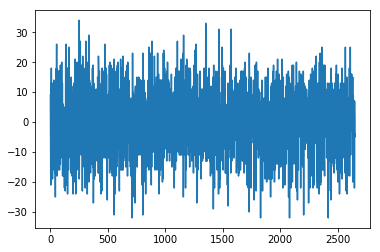

In [10]:
plt.plot(pipe.tracking_error)

In [14]:
print(f'standard deviation of tracking error: {np.std(pipe.tracking_error)}')

standard deviation of tracking error: 10.302751093745767


### Run backtest with retraining

Next we run another backtest on the dataset, but with retraining enabled. Our backtest system uses a simple time-based strategy to initiate the retraining of the pipeline: the end of each month. In this case we do not use a sliding window data snapshot methodology put rather keep retraining each month on the fully available data at that time.

In the console output you will see a message on the last day of each month that shows it is rebuilding a model.

In [29]:
import examples.simple.backtest_pkg.PipelineControl as pc

pipe = pc.PipelineControl(data_path='examples/simple/data/fixed_process_data.csv', 
                          prediction_path='examples/simple/data/predictions.csv',
                          retraining_flag=True)
pipe.runPipeline()

tdate=2008-08-28, pdate=2008-08-29, prediction=0, tracking_error=0
tdate=2008-08-29, pdate=2008-08-30, prediction=0, tracking_error=0
tdate=2008-08-30, pdate=2008-08-31, prediction=0, tracking_error=0
2008-08-31 00:00:00 rebuilding model....
model built
tdate=2008-08-31, pdate=2008-09-01, prediction=124.0, tracking_error=0
tdate=2008-09-01, pdate=2008-09-02, prediction=212.0, tracking_error=0
tdate=2008-09-02, pdate=2008-09-03, prediction=106.0, tracking_error=0
tdate=2008-09-03, pdate=2008-09-04, prediction=204.0, tracking_error=0
tdate=2008-09-04, pdate=2008-09-05, prediction=180.0, tracking_error=0
tdate=2008-09-05, pdate=2008-09-06, prediction=223.0, tracking_error=0
tdate=2008-09-06, pdate=2008-09-07, prediction=203.0, tracking_error=0
tdate=2008-09-07, pdate=2008-09-08, prediction=174.0, tracking_error=0
tdate=2008-09-08, pdate=2008-09-09, prediction=234.0, tracking_error=0
tdate=2008-09-09, pdate=2008-09-10, prediction=117.0, tracking_error=0
tdate=2008-09-10, pdate=2008-09-11, 

tdate=2009-06-20, pdate=2009-06-21, prediction=241.0, tracking_error=0
tdate=2009-06-21, pdate=2009-06-22, prediction=264.0, tracking_error=0
tdate=2009-06-22, pdate=2009-06-23, prediction=196.0, tracking_error=0
tdate=2009-06-23, pdate=2009-06-24, prediction=69.0, tracking_error=0
tdate=2009-06-24, pdate=2009-06-25, prediction=56.0, tracking_error=0
tdate=2009-06-25, pdate=2009-06-26, prediction=87.0, tracking_error=0
tdate=2009-06-26, pdate=2009-06-27, prediction=217.0, tracking_error=0
tdate=2009-06-27, pdate=2009-06-28, prediction=156.0, tracking_error=0
tdate=2009-06-28, pdate=2009-06-29, prediction=249.0, tracking_error=0
tdate=2009-06-29, pdate=2009-06-30, prediction=12.0, tracking_error=0
2009-06-30 00:00:00 rebuilding model....
model built
tdate=2009-06-30, pdate=2009-07-01, prediction=111.0, tracking_error=0
tdate=2009-07-01, pdate=2009-07-02, prediction=205.0, tracking_error=0
tdate=2009-07-02, pdate=2009-07-03, prediction=208.0, tracking_error=0
tdate=2009-07-03, pdate=2009

tdate=2010-03-21, pdate=2010-03-22, prediction=272.0, tracking_error=0
tdate=2010-03-22, pdate=2010-03-23, prediction=121.0, tracking_error=0
tdate=2010-03-23, pdate=2010-03-24, prediction=122.0, tracking_error=0
tdate=2010-03-24, pdate=2010-03-25, prediction=133.0, tracking_error=0
tdate=2010-03-25, pdate=2010-03-26, prediction=30.0, tracking_error=0
tdate=2010-03-26, pdate=2010-03-27, prediction=174.0, tracking_error=0
tdate=2010-03-27, pdate=2010-03-28, prediction=134.0, tracking_error=0
tdate=2010-03-28, pdate=2010-03-29, prediction=181.0, tracking_error=0
tdate=2010-03-29, pdate=2010-03-30, prediction=200.0, tracking_error=0
tdate=2010-03-30, pdate=2010-03-31, prediction=208.0, tracking_error=0
2010-03-31 00:00:00 rebuilding model....
model built
tdate=2010-03-31, pdate=2010-04-01, prediction=96.0, tracking_error=0
tdate=2010-04-01, pdate=2010-04-02, prediction=127.0, tracking_error=0
tdate=2010-04-02, pdate=2010-04-03, prediction=134.0, tracking_error=0
tdate=2010-04-03, pdate=20

model built
tdate=2010-11-30, pdate=2010-12-01, prediction=62.0, tracking_error=0
tdate=2010-12-01, pdate=2010-12-02, prediction=183.0, tracking_error=0
tdate=2010-12-02, pdate=2010-12-03, prediction=251.0, tracking_error=0
tdate=2010-12-03, pdate=2010-12-04, prediction=200.0, tracking_error=0
tdate=2010-12-04, pdate=2010-12-05, prediction=222.0, tracking_error=0
tdate=2010-12-05, pdate=2010-12-06, prediction=138.0, tracking_error=0
tdate=2010-12-06, pdate=2010-12-07, prediction=174.0, tracking_error=0
tdate=2010-12-07, pdate=2010-12-08, prediction=146.0, tracking_error=0
tdate=2010-12-08, pdate=2010-12-09, prediction=203.0, tracking_error=0
tdate=2010-12-09, pdate=2010-12-10, prediction=74.0, tracking_error=0
tdate=2010-12-10, pdate=2010-12-11, prediction=107.0, tracking_error=0
tdate=2010-12-11, pdate=2010-12-12, prediction=120.0, tracking_error=0
tdate=2010-12-12, pdate=2010-12-13, prediction=101.0, tracking_error=0
tdate=2010-12-13, pdate=2010-12-14, prediction=155.0, tracking_erro

tdate=2011-07-09, pdate=2011-07-10, prediction=98.0, tracking_error=10.265842567928344
tdate=2011-07-10, pdate=2011-07-11, prediction=218.0, tracking_error=10.29738877007752
tdate=2011-07-11, pdate=2011-07-12, prediction=165.0, tracking_error=10.210097636653629
tdate=2011-07-12, pdate=2011-07-13, prediction=105.0, tracking_error=10.285714285714286
tdate=2011-07-13, pdate=2011-07-14, prediction=189.0, tracking_error=10.22029353785888
tdate=2011-07-14, pdate=2011-07-15, prediction=162.0, tracking_error=10.230597675435032
tdate=2011-07-15, pdate=2011-07-16, prediction=182.0, tracking_error=10.185756239843695
tdate=2011-07-16, pdate=2011-07-17, prediction=107.0, tracking_error=10.365756808084162
tdate=2011-07-17, pdate=2011-07-18, prediction=83.0, tracking_error=10.282431378897133
tdate=2011-07-18, pdate=2011-07-19, prediction=216.0, tracking_error=10.731370557835879
tdate=2011-07-19, pdate=2011-07-20, prediction=124.0, tracking_error=10.757872651207201
tdate=2011-07-20, pdate=2011-07-21, 

tdate=2012-01-23, pdate=2012-01-24, prediction=258.0, tracking_error=10.86045777734835
tdate=2012-01-24, pdate=2012-01-25, prediction=210.0, tracking_error=10.841822857133975
tdate=2012-01-25, pdate=2012-01-26, prediction=62.0, tracking_error=10.832752924551711
tdate=2012-01-26, pdate=2012-01-27, prediction=187.0, tracking_error=10.820737683349833
tdate=2012-01-27, pdate=2012-01-28, prediction=268.0, tracking_error=10.799455336354454
tdate=2012-01-28, pdate=2012-01-29, prediction=106.0, tracking_error=10.779122451054425
tdate=2012-01-29, pdate=2012-01-30, prediction=186.0, tracking_error=10.95388515550533
tdate=2012-01-30, pdate=2012-01-31, prediction=41.0, tracking_error=10.98799147124341
2012-01-31 00:00:00 rebuilding model....
model built
tdate=2012-01-31, pdate=2012-02-01, prediction=127.0, tracking_error=11.034412147854894
tdate=2012-02-01, pdate=2012-02-02, prediction=126.0, tracking_error=11.054963598155377
tdate=2012-02-02, pdate=2012-02-03, prediction=55.0, tracking_error=11.0

tdate=2012-07-09, pdate=2012-07-10, prediction=249.0, tracking_error=11.026173028663491
tdate=2012-07-10, pdate=2012-07-11, prediction=101.0, tracking_error=11.02839306647785
tdate=2012-07-11, pdate=2012-07-12, prediction=86.0, tracking_error=11.028037745392616
tdate=2012-07-12, pdate=2012-07-13, prediction=96.0, tracking_error=11.023840671206331
tdate=2012-07-13, pdate=2012-07-14, prediction=4.0, tracking_error=11.010971532196432
tdate=2012-07-14, pdate=2012-07-15, prediction=119.0, tracking_error=10.999402162468947
tdate=2012-07-15, pdate=2012-07-16, prediction=157.0, tracking_error=11.018044071551744
tdate=2012-07-16, pdate=2012-07-17, prediction=246.0, tracking_error=11.056725706527098
tdate=2012-07-17, pdate=2012-07-18, prediction=56.0, tracking_error=11.085907327316121
tdate=2012-07-18, pdate=2012-07-19, prediction=173.0, tracking_error=11.081048029192385
tdate=2012-07-19, pdate=2012-07-20, prediction=181.0, tracking_error=11.072842053234051
tdate=2012-07-20, pdate=2012-07-21, pr

model built
tdate=2013-02-28, pdate=2013-03-01, prediction=216.0, tracking_error=11.008712094940257
tdate=2013-03-01, pdate=2013-03-02, prediction=154.0, tracking_error=11.002131637474202
tdate=2013-03-02, pdate=2013-03-03, prediction=73.0, tracking_error=10.997309770481538
tdate=2013-03-03, pdate=2013-03-04, prediction=212.0, tracking_error=10.989830534398507
tdate=2013-03-04, pdate=2013-03-05, prediction=153.0, tracking_error=10.988694459177568
tdate=2013-03-05, pdate=2013-03-06, prediction=202.0, tracking_error=10.99351122945804
tdate=2013-03-06, pdate=2013-03-07, prediction=164.0, tracking_error=10.99042726706588
tdate=2013-03-07, pdate=2013-03-08, prediction=174.0, tracking_error=10.983266983759071
tdate=2013-03-08, pdate=2013-03-09, prediction=226.0, tracking_error=10.9750810018141
tdate=2013-03-09, pdate=2013-03-10, prediction=172.0, tracking_error=10.969868197684786
tdate=2013-03-10, pdate=2013-03-11, prediction=176.0, tracking_error=10.9630649005505
tdate=2013-03-11, pdate=201

tdate=2013-10-24, pdate=2013-10-25, prediction=260.0, tracking_error=10.818222198352805
tdate=2013-10-25, pdate=2013-10-26, prediction=228.0, tracking_error=10.850085251429723
tdate=2013-10-26, pdate=2013-10-27, prediction=254.0, tracking_error=10.846531195125138
tdate=2013-10-27, pdate=2013-10-28, prediction=29.0, tracking_error=10.841236044075195
tdate=2013-10-28, pdate=2013-10-29, prediction=43.0, tracking_error=10.837016848626778
tdate=2013-10-29, pdate=2013-10-30, prediction=44.0, tracking_error=10.830920099857497
tdate=2013-10-30, pdate=2013-10-31, prediction=164.0, tracking_error=10.824833629351701
2013-10-31 00:00:00 rebuilding model....
model built
tdate=2013-10-31, pdate=2013-11-01, prediction=104.0, tracking_error=10.8249991996738
tdate=2013-11-01, pdate=2013-11-02, prediction=194.0, tracking_error=10.819743345182522
tdate=2013-11-02, pdate=2013-11-03, prediction=153.0, tracking_error=10.822368065292435
tdate=2013-11-03, pdate=2013-11-04, prediction=68.0, tracking_error=10.8

tdate=2014-06-05, pdate=2014-06-06, prediction=202.0, tracking_error=10.592000353903277
tdate=2014-06-06, pdate=2014-06-07, prediction=86.0, tracking_error=10.597806618717472
tdate=2014-06-07, pdate=2014-06-08, prediction=80.0, tracking_error=10.593163513385859
tdate=2014-06-08, pdate=2014-06-09, prediction=201.0, tracking_error=10.588840963455555
tdate=2014-06-09, pdate=2014-06-10, prediction=72.0, tracking_error=10.584291238856395
tdate=2014-06-10, pdate=2014-06-11, prediction=220.0, tracking_error=10.579859519815654
tdate=2014-06-11, pdate=2014-06-12, prediction=222.0, tracking_error=10.579553688661406
tdate=2014-06-12, pdate=2014-06-13, prediction=58.0, tracking_error=10.577676951643866
tdate=2014-06-13, pdate=2014-06-14, prediction=219.0, tracking_error=10.573541210847505
tdate=2014-06-14, pdate=2014-06-15, prediction=121.0, tracking_error=10.569016612843702
tdate=2014-06-15, pdate=2014-06-16, prediction=225.0, tracking_error=10.566495179096922
tdate=2014-06-16, pdate=2014-06-17, 

model built
tdate=2014-12-31, pdate=2015-01-01, prediction=53.0, tracking_error=10.478189614893855
tdate=2015-01-01, pdate=2015-01-02, prediction=130.0, tracking_error=10.474314357375013
tdate=2015-01-02, pdate=2015-01-03, prediction=72.0, tracking_error=10.470443392508896
tdate=2015-01-03, pdate=2015-01-04, prediction=105.0, tracking_error=10.47033916264893
tdate=2015-01-04, pdate=2015-01-05, prediction=139.0, tracking_error=10.469092574096454
tdate=2015-01-05, pdate=2015-01-06, prediction=98.0, tracking_error=10.46629131138451
tdate=2015-01-06, pdate=2015-01-07, prediction=103.0, tracking_error=10.463119232037915
tdate=2015-01-07, pdate=2015-01-08, prediction=122.0, tracking_error=10.465587993545247
tdate=2015-01-08, pdate=2015-01-09, prediction=137.0, tracking_error=10.465738885699295
tdate=2015-01-09, pdate=2015-01-10, prediction=171.0, tracking_error=10.463239532180994
tdate=2015-01-10, pdate=2015-01-11, prediction=251.0, tracking_error=10.460895017236222
tdate=2015-01-11, pdate=2

model built
tdate=2015-08-31, pdate=2015-09-01, prediction=175.0, tracking_error=10.44376758616448
tdate=2015-09-01, pdate=2015-09-02, prediction=131.0, tracking_error=10.440446385490738
tdate=2015-09-02, pdate=2015-09-03, prediction=132.0, tracking_error=10.440103956917147
tdate=2015-09-03, pdate=2015-09-04, prediction=92.0, tracking_error=10.437564115658171
tdate=2015-09-04, pdate=2015-09-05, prediction=49.0, tracking_error=10.436647063855917
tdate=2015-09-05, pdate=2015-09-06, prediction=144.0, tracking_error=10.434762923582968
tdate=2015-09-06, pdate=2015-09-07, prediction=261.0, tracking_error=10.443514112197755
tdate=2015-09-07, pdate=2015-09-08, prediction=23.0, tracking_error=10.444675474915416
tdate=2015-09-08, pdate=2015-09-09, prediction=167.0, tracking_error=10.44145180596676
tdate=2015-09-09, pdate=2015-09-10, prediction=74.0, tracking_error=10.44680854990071
tdate=2015-09-10, pdate=2015-09-11, prediction=66.0, tracking_error=10.444202058909454
tdate=2015-09-11, pdate=2015

model built
tdate=2016-03-31, pdate=2016-04-01, prediction=206.0, tracking_error=10.406481772215328
tdate=2016-04-01, pdate=2016-04-02, prediction=245.0, tracking_error=10.42204810645244
tdate=2016-04-02, pdate=2016-04-03, prediction=192.0, tracking_error=10.420129147477448
tdate=2016-04-03, pdate=2016-04-04, prediction=13.0, tracking_error=10.417906609912693
tdate=2016-04-04, pdate=2016-04-05, prediction=131.0, tracking_error=10.420168324080297
tdate=2016-04-05, pdate=2016-04-06, prediction=152.0, tracking_error=10.421211382208936
tdate=2016-04-06, pdate=2016-04-07, prediction=27.0, tracking_error=10.421048682688618
tdate=2016-04-07, pdate=2016-04-08, prediction=66.0, tracking_error=10.418242669988366
tdate=2016-04-08, pdate=2016-04-09, prediction=85.0, tracking_error=10.415580271205927
tdate=2016-04-09, pdate=2016-04-10, prediction=205.0, tracking_error=10.415416208997717
tdate=2016-04-10, pdate=2016-04-11, prediction=116.0, tracking_error=10.422089065652163
tdate=2016-04-11, pdate=2

model built
tdate=2016-11-30, pdate=2016-12-01, prediction=70.0, tracking_error=10.370331659290583
tdate=2016-12-01, pdate=2016-12-02, prediction=109.0, tracking_error=10.36778529800505
tdate=2016-12-02, pdate=2016-12-03, prediction=16.0, tracking_error=10.373825205534715
tdate=2016-12-03, pdate=2016-12-04, prediction=41.0, tracking_error=10.371468972152854
tdate=2016-12-04, pdate=2016-12-05, prediction=88.0, tracking_error=10.368902740442861
tdate=2016-12-05, pdate=2016-12-06, prediction=156.0, tracking_error=10.367872324645749
tdate=2016-12-06, pdate=2016-12-07, prediction=196.0, tracking_error=10.371422140101185
tdate=2016-12-07, pdate=2016-12-08, prediction=96.0, tracking_error=10.379365313930206
tdate=2016-12-08, pdate=2016-12-09, prediction=163.0, tracking_error=10.376825927215467
tdate=2016-12-09, pdate=2016-12-10, prediction=261.0, tracking_error=10.37447889960272
tdate=2016-12-10, pdate=2016-12-11, prediction=265.0, tracking_error=10.376577531897011
tdate=2016-12-11, pdate=201

tdate=2017-07-09, pdate=2017-07-10, prediction=168.0, tracking_error=10.316408424675798
tdate=2017-07-10, pdate=2017-07-11, prediction=236.0, tracking_error=10.314651019123186
tdate=2017-07-11, pdate=2017-07-12, prediction=75.0, tracking_error=10.31374118033244
tdate=2017-07-12, pdate=2017-07-13, prediction=35.0, tracking_error=10.311976124680557
tdate=2017-07-13, pdate=2017-07-14, prediction=73.0, tracking_error=10.310728821704451
tdate=2017-07-14, pdate=2017-07-15, prediction=179.0, tracking_error=10.3120681549596
tdate=2017-07-15, pdate=2017-07-16, prediction=190.0, tracking_error=10.312368968609752
tdate=2017-07-16, pdate=2017-07-17, prediction=230.0, tracking_error=10.310071999505961
tdate=2017-07-17, pdate=2017-07-18, prediction=191.0, tracking_error=10.30856303025435
tdate=2017-07-18, pdate=2017-07-19, prediction=197.0, tracking_error=10.306352389979379
tdate=2017-07-19, pdate=2017-07-20, prediction=52.0, tracking_error=10.319736916374175
tdate=2017-07-20, pdate=2017-07-21, pred

model built
tdate=2018-01-31, pdate=2018-02-01, prediction=69.0, tracking_error=10.334764380310872
tdate=2018-02-01, pdate=2018-02-02, prediction=115.0, tracking_error=10.339146227931314
tdate=2018-02-02, pdate=2018-02-03, prediction=184.0, tracking_error=10.339474466380485
tdate=2018-02-03, pdate=2018-02-04, prediction=173.0, tracking_error=10.341740818919165
tdate=2018-02-04, pdate=2018-02-05, prediction=200.0, tracking_error=10.341556839060821
tdate=2018-02-05, pdate=2018-02-06, prediction=152.0, tracking_error=10.340184715375056
tdate=2018-02-06, pdate=2018-02-07, prediction=273.0, tracking_error=10.338371560870323
tdate=2018-02-07, pdate=2018-02-08, prediction=84.0, tracking_error=10.33965766711273
tdate=2018-02-08, pdate=2018-02-09, prediction=148.0, tracking_error=10.338064831878226
tdate=2018-02-09, pdate=2018-02-10, prediction=171.0, tracking_error=10.339230863972906
tdate=2018-02-10, pdate=2018-02-11, prediction=238.0, tracking_error=10.339047949393542
tdate=2018-02-11, pdate

model built
tdate=2018-07-31, pdate=2018-08-01, prediction=7.0, tracking_error=10.30943047840741
tdate=2018-08-01, pdate=2018-08-02, prediction=141.0, tracking_error=10.307785834939299
tdate=2018-08-02, pdate=2018-08-03, prediction=84.0, tracking_error=10.3067679110904
tdate=2018-08-03, pdate=2018-08-04, prediction=143.0, tracking_error=10.305296040839714
tdate=2018-08-04, pdate=2018-08-05, prediction=155.0, tracking_error=10.304278358146552
tdate=2018-08-05, pdate=2018-08-06, prediction=99.0, tracking_error=10.302343331998614
tdate=2018-08-06, pdate=2018-08-07, prediction=197.0, tracking_error=10.30132642322316
tdate=2018-08-07, pdate=2018-08-08, prediction=100.0, tracking_error=10.303595294705659
tdate=2018-08-08, pdate=2018-08-09, prediction=241.0, tracking_error=10.308907245510706
tdate=2018-08-09, pdate=2018-08-10, prediction=16.0, tracking_error=10.306950543139173
tdate=2018-08-10, pdate=2018-08-11, prediction=127.0, tracking_error=10.305310477751844
tdate=2018-08-11, pdate=2018-

Again, we see that the tracking error is close to our dataset.

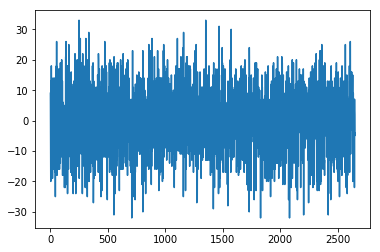

In [30]:
plt.plot(pipe.tracking_error)

In [31]:
np.std(pipe.tracking_error)

10.298510304366456

## Varying process

Now we are going to append some additional data to our original set below, but in this case we change the parameters in our underlying equation to $\phi_1=-2$ and $\phi_2=2$. We still keep the same noise level (i.e. $\sigma(r)=10$).

In [19]:
n = 3652
phi1 = -2
phi2 = 2
y = np.zeros(n)
y[1:n] = phi1*x[0:(n-1)] + phi2*z[0:(n-1)] + r[1:n]

In [20]:
datelist = pd.date_range(start=pd.datetime.today(), periods=n, normalize=True).tolist()
my_data2 = pd.DataFrame({'date': datelist, 'input1': x, 'input2': z, 'input3': u1, 'input4': u2, 'target': y})
my_data2 = my_data2.drop(0)
my_data2.head(5)

,date,input1,input2,input3,input4,target
1,2018-08-26,41.0,29.0,28.0,183.0,-120.0
2,2018-08-27,34.0,9.0,56.0,105.0,-43.0
3,2018-08-28,67.0,7.0,17.0,111.0,-54.0
4,2018-08-29,90.0,24.0,58.0,187.0,-126.0
5,2018-08-30,35.0,13.0,45.0,147.0,-125.0


In [23]:
full_data = my_data.append(my_data2)
len(full_data)

7302

In [24]:
full_data.to_csv('examples/simple/data/varying_data.csv', index=False)

### Run backtest with no retraining

We run our backtest with without any retraining i.e. we fit an initial model on some data and use that same model each day going forward to make a prediction.

In [21]:
pipe = pc.PipelineControl(data_path='examples/simple/data/varying_data.csv',
                          prediction_path='examples/simple/data/predictions.csv',
                          retraining_flag=False)
pipe.runPipeline()

tdate=2008-08-28, pdate=2008-08-29, prediction=0, tracking_error=0
tdate=2008-08-29, pdate=2008-08-30, prediction=0, tracking_error=0
tdate=2008-08-30, pdate=2008-08-31, prediction=0, tracking_error=0
tdate=2008-08-31, pdate=2008-09-01, prediction=0, tracking_error=0
tdate=2008-09-01, pdate=2008-09-02, prediction=0, tracking_error=0
tdate=2008-09-02, pdate=2008-09-03, prediction=0, tracking_error=0
tdate=2008-09-03, pdate=2008-09-04, prediction=0, tracking_error=0
tdate=2008-09-04, pdate=2008-09-05, prediction=0, tracking_error=0
tdate=2008-09-05, pdate=2008-09-06, prediction=0, tracking_error=0
tdate=2008-09-06, pdate=2008-09-07, prediction=0, tracking_error=0
tdate=2008-09-07, pdate=2008-09-08, prediction=0, tracking_error=0
tdate=2008-09-08, pdate=2008-09-09, prediction=0, tracking_error=0
tdate=2008-09-09, pdate=2008-09-10, prediction=0, tracking_error=0
tdate=2008-09-10, pdate=2008-09-11, prediction=0, tracking_error=0
tdate=2008-09-11, pdate=2008-09-12, prediction=0, tracking_err

tdate=2010-08-30, pdate=2010-08-31, prediction=0, tracking_error=0
tdate=2010-08-31, pdate=2010-09-01, prediction=0, tracking_error=0
tdate=2010-09-01, pdate=2010-09-02, prediction=0, tracking_error=0
tdate=2010-09-02, pdate=2010-09-03, prediction=0, tracking_error=0
tdate=2010-09-03, pdate=2010-09-04, prediction=0, tracking_error=0
tdate=2010-09-04, pdate=2010-09-05, prediction=0, tracking_error=0
tdate=2010-09-05, pdate=2010-09-06, prediction=0, tracking_error=0
tdate=2010-09-06, pdate=2010-09-07, prediction=0, tracking_error=0
tdate=2010-09-07, pdate=2010-09-08, prediction=0, tracking_error=0
tdate=2010-09-08, pdate=2010-09-09, prediction=0, tracking_error=0
tdate=2010-09-09, pdate=2010-09-10, prediction=0, tracking_error=0
tdate=2010-09-10, pdate=2010-09-11, prediction=0, tracking_error=0
tdate=2010-09-11, pdate=2010-09-12, prediction=0, tracking_error=0
tdate=2010-09-12, pdate=2010-09-13, prediction=0, tracking_error=0
tdate=2010-09-13, pdate=2010-09-14, prediction=0, tracking_err

tdate=2011-09-26, pdate=2011-09-27, prediction=209.0, tracking_error=9.815416445571733
tdate=2011-09-27, pdate=2011-09-28, prediction=189.0, tracking_error=9.789739642481495
tdate=2011-09-28, pdate=2011-09-29, prediction=65.0, tracking_error=9.762306213454133
tdate=2011-09-29, pdate=2011-09-30, prediction=206.0, tracking_error=9.816281118631434
tdate=2011-09-30, pdate=2011-10-01, prediction=118.0, tracking_error=9.781999733128167
tdate=2011-10-01, pdate=2011-10-02, prediction=104.0, tracking_error=9.757925014659417
tdate=2011-10-02, pdate=2011-10-03, prediction=244.0, tracking_error=9.818058161796097
tdate=2011-10-03, pdate=2011-10-04, prediction=177.0, tracking_error=9.858721370053097
tdate=2011-10-04, pdate=2011-10-05, prediction=239.0, tracking_error=9.866134357335207
tdate=2011-10-05, pdate=2011-10-06, prediction=31.0, tracking_error=9.83320747559954
tdate=2011-10-06, pdate=2011-10-07, prediction=68.0, tracking_error=9.819428684919338
tdate=2011-10-07, pdate=2011-10-08, prediction=

tdate=2012-06-04, pdate=2012-06-05, prediction=148.0, tracking_error=9.744482300525302
tdate=2012-06-05, pdate=2012-06-06, prediction=118.0, tracking_error=9.731614798511176
tdate=2012-06-06, pdate=2012-06-07, prediction=258.0, tracking_error=9.724439692911849
tdate=2012-06-07, pdate=2012-06-08, prediction=55.0, tracking_error=9.711957889055181
tdate=2012-06-08, pdate=2012-06-09, prediction=126.0, tracking_error=9.700894631896471
tdate=2012-06-09, pdate=2012-06-10, prediction=79.0, tracking_error=9.693933245434858
tdate=2012-06-10, pdate=2012-06-11, prediction=159.0, tracking_error=9.696123289038344
tdate=2012-06-11, pdate=2012-06-12, prediction=128.0, tracking_error=9.707849580557614
tdate=2012-06-12, pdate=2012-06-13, prediction=79.0, tracking_error=9.757079849269594
tdate=2012-06-13, pdate=2012-06-14, prediction=59.0, tracking_error=9.746063029949436
tdate=2012-06-14, pdate=2012-06-15, prediction=190.0, tracking_error=9.73747093674614
tdate=2012-06-15, pdate=2012-06-16, prediction=8

tdate=2013-03-23, pdate=2013-03-24, prediction=191.0, tracking_error=9.822550564503821
tdate=2013-03-24, pdate=2013-03-25, prediction=90.0, tracking_error=9.860585429940905
tdate=2013-03-25, pdate=2013-03-26, prediction=203.0, tracking_error=9.853258919719831
tdate=2013-03-26, pdate=2013-03-27, prediction=42.0, tracking_error=9.869169681593362
tdate=2013-03-27, pdate=2013-03-28, prediction=218.0, tracking_error=9.868672392414695
tdate=2013-03-28, pdate=2013-03-29, prediction=168.0, tracking_error=9.86454288335213
tdate=2013-03-29, pdate=2013-03-30, prediction=173.0, tracking_error=9.86897270348957
tdate=2013-03-30, pdate=2013-03-31, prediction=89.0, tracking_error=9.869934229498115
tdate=2013-03-31, pdate=2013-04-01, prediction=196.0, tracking_error=9.88817560480352
tdate=2013-04-01, pdate=2013-04-02, prediction=15.0, tracking_error=9.881774861914188
tdate=2013-04-02, pdate=2013-04-03, prediction=182.0, tracking_error=9.887974394581022
tdate=2013-04-03, pdate=2013-04-04, prediction=74.

tdate=2013-11-16, pdate=2013-11-17, prediction=127.0, tracking_error=10.014149127238875
tdate=2013-11-17, pdate=2013-11-18, prediction=247.0, tracking_error=10.025324226266152
tdate=2013-11-18, pdate=2013-11-19, prediction=57.0, tracking_error=10.026951231795408
tdate=2013-11-19, pdate=2013-11-20, prediction=81.0, tracking_error=10.021580144405867
tdate=2013-11-20, pdate=2013-11-21, prediction=172.0, tracking_error=10.016097733202917
tdate=2013-11-21, pdate=2013-11-22, prediction=206.0, tracking_error=10.023900855641346
tdate=2013-11-22, pdate=2013-11-23, prediction=56.0, tracking_error=10.018545753149633
tdate=2013-11-23, pdate=2013-11-24, prediction=173.0, tracking_error=10.013174291416144
tdate=2013-11-24, pdate=2013-11-25, prediction=86.0, tracking_error=10.012542285349694
tdate=2013-11-25, pdate=2013-11-26, prediction=128.0, tracking_error=10.009315360960333
tdate=2013-11-26, pdate=2013-11-27, prediction=228.0, tracking_error=10.004171143268993
tdate=2013-11-27, pdate=2013-11-28, 

tdate=2014-07-24, pdate=2014-07-25, prediction=70.0, tracking_error=9.781536811261633
tdate=2014-07-25, pdate=2014-07-26, prediction=179.0, tracking_error=9.784520773952167
tdate=2014-07-26, pdate=2014-07-27, prediction=169.0, tracking_error=9.784907300862828
tdate=2014-07-27, pdate=2014-07-28, prediction=188.0, tracking_error=9.789048418298416
tdate=2014-07-28, pdate=2014-07-29, prediction=120.0, tracking_error=9.793732608739102
tdate=2014-07-29, pdate=2014-07-30, prediction=66.0, tracking_error=9.789733560952762
tdate=2014-07-30, pdate=2014-07-31, prediction=175.0, tracking_error=9.785977828651546
tdate=2014-07-31, pdate=2014-08-01, prediction=127.0, tracking_error=9.784433319843586
tdate=2014-08-01, pdate=2014-08-02, prediction=181.0, tracking_error=9.801856666621273
tdate=2014-08-02, pdate=2014-08-03, prediction=75.0, tracking_error=9.797995192413051
tdate=2014-08-03, pdate=2014-08-04, prediction=33.0, tracking_error=9.797990521474473
tdate=2014-08-04, pdate=2014-08-05, prediction=

tdate=2015-03-21, pdate=2015-03-22, prediction=165.0, tracking_error=9.905581851226689
tdate=2015-03-22, pdate=2015-03-23, prediction=159.0, tracking_error=9.902153021460983
tdate=2015-03-23, pdate=2015-03-24, prediction=235.0, tracking_error=9.906967303399298
tdate=2015-03-24, pdate=2015-03-25, prediction=120.0, tracking_error=9.906213237876809
tdate=2015-03-25, pdate=2015-03-26, prediction=224.0, tracking_error=9.9026993913607
tdate=2015-03-26, pdate=2015-03-27, prediction=104.0, tracking_error=9.901944798298025
tdate=2015-03-27, pdate=2015-03-28, prediction=105.0, tracking_error=9.898592926408313
tdate=2015-03-28, pdate=2015-03-29, prediction=154.0, tracking_error=9.905726230197798
tdate=2015-03-29, pdate=2015-03-30, prediction=141.0, tracking_error=9.90406611965823
tdate=2015-03-30, pdate=2015-03-31, prediction=142.0, tracking_error=9.900566229948854
tdate=2015-03-31, pdate=2015-04-01, prediction=118.0, tracking_error=9.899228113612185
tdate=2015-04-01, pdate=2015-04-02, prediction

tdate=2015-12-01, pdate=2015-12-02, prediction=205.0, tracking_error=10.03960279133585
tdate=2015-12-02, pdate=2015-12-03, prediction=210.0, tracking_error=10.04766592148652
tdate=2015-12-03, pdate=2015-12-04, prediction=84.0, tracking_error=10.048141413734417
tdate=2015-12-04, pdate=2015-12-05, prediction=104.0, tracking_error=10.047125003723455
tdate=2015-12-05, pdate=2015-12-06, prediction=59.0, tracking_error=10.044235441380344
tdate=2015-12-06, pdate=2015-12-07, prediction=107.0, tracking_error=10.042355347915384
tdate=2015-12-07, pdate=2015-12-08, prediction=25.0, tracking_error=10.0416574680506
tdate=2015-12-08, pdate=2015-12-09, prediction=144.0, tracking_error=10.048140208878092
tdate=2015-12-09, pdate=2015-12-10, prediction=212.0, tracking_error=10.045156626477123
tdate=2015-12-10, pdate=2015-12-11, prediction=199.0, tracking_error=10.050581104780488
tdate=2015-12-11, pdate=2015-12-12, prediction=73.0, tracking_error=10.048712089888317
tdate=2015-12-12, pdate=2015-12-13, pred

tdate=2016-07-29, pdate=2016-07-30, prediction=84.0, tracking_error=10.058688506248139
tdate=2016-07-30, pdate=2016-07-31, prediction=13.0, tracking_error=10.056422397093598
tdate=2016-07-31, pdate=2016-08-01, prediction=23.0, tracking_error=10.053769214715212
tdate=2016-08-01, pdate=2016-08-02, prediction=155.0, tracking_error=10.051734810747094
tdate=2016-08-02, pdate=2016-08-03, prediction=230.0, tracking_error=10.052170207377227
tdate=2016-08-03, pdate=2016-08-04, prediction=167.0, tracking_error=10.054055814720654
tdate=2016-08-04, pdate=2016-08-05, prediction=107.0, tracking_error=10.055084253409
tdate=2016-08-05, pdate=2016-08-06, prediction=125.0, tracking_error=10.05305178234471
tdate=2016-08-06, pdate=2016-08-07, prediction=211.0, tracking_error=10.056167140494326
tdate=2016-08-07, pdate=2016-08-08, prediction=248.0, tracking_error=10.053611098174581
tdate=2016-08-08, pdate=2016-08-09, prediction=275.0, tracking_error=10.056977866597679
tdate=2016-08-09, pdate=2016-08-10, pre

tdate=2017-04-03, pdate=2017-04-04, prediction=43.0, tracking_error=10.079340398808487
tdate=2017-04-04, pdate=2017-04-05, prediction=91.0, tracking_error=10.077765714662243
tdate=2017-04-05, pdate=2017-04-06, prediction=264.0, tracking_error=10.075488739242266
tdate=2017-04-06, pdate=2017-04-07, prediction=118.0, tracking_error=10.079986643913038
tdate=2017-04-07, pdate=2017-04-08, prediction=54.0, tracking_error=10.08166263764178
tdate=2017-04-08, pdate=2017-04-09, prediction=253.0, tracking_error=10.082206720755458
tdate=2017-04-09, pdate=2017-04-10, prediction=80.0, tracking_error=10.080742104524795
tdate=2017-04-10, pdate=2017-04-11, prediction=252.0, tracking_error=10.083038102071068
tdate=2017-04-11, pdate=2017-04-12, prediction=117.0, tracking_error=10.083573130771425
tdate=2017-04-12, pdate=2017-04-13, prediction=105.0, tracking_error=10.081243677944945
tdate=2017-04-13, pdate=2017-04-14, prediction=134.0, tracking_error=10.079437428520103
tdate=2017-04-14, pdate=2017-04-15, p

tdate=2017-11-15, pdate=2017-11-16, prediction=197.0, tracking_error=9.988867753287986
tdate=2017-11-16, pdate=2017-11-17, prediction=28.0, tracking_error=9.992358198189617
tdate=2017-11-17, pdate=2017-11-18, prediction=232.0, tracking_error=9.990475245270117
tdate=2017-11-18, pdate=2017-11-19, prediction=199.0, tracking_error=9.989628191398065
tdate=2017-11-19, pdate=2017-11-20, prediction=218.0, tracking_error=9.987814173993351
tdate=2017-11-20, pdate=2017-11-21, prediction=192.0, tracking_error=9.990008452252019
tdate=2017-11-21, pdate=2017-11-22, prediction=77.0, tracking_error=9.993119118613597
tdate=2017-11-22, pdate=2017-11-23, prediction=246.0, tracking_error=9.991170402054296
tdate=2017-11-23, pdate=2017-11-24, prediction=123.0, tracking_error=9.989077744912482
tdate=2017-11-24, pdate=2017-11-25, prediction=178.0, tracking_error=9.987361038385414
tdate=2017-11-25, pdate=2017-11-26, prediction=226.0, tracking_error=9.994298770418348
tdate=2017-11-26, pdate=2017-11-27, predictio

tdate=2018-07-23, pdate=2018-07-24, prediction=216.0, tracking_error=10.009069229811464
tdate=2018-07-24, pdate=2018-07-25, prediction=19.0, tracking_error=10.012526871213444
tdate=2018-07-25, pdate=2018-07-26, prediction=247.0, tracking_error=10.011905594290171
tdate=2018-07-26, pdate=2018-07-27, prediction=67.0, tracking_error=10.012207302017025
tdate=2018-07-27, pdate=2018-07-28, prediction=241.0, tracking_error=10.011762649002174
tdate=2018-07-28, pdate=2018-07-29, prediction=261.0, tracking_error=10.009864515635392
tdate=2018-07-29, pdate=2018-07-30, prediction=45.0, tracking_error=10.008389027339145
tdate=2018-07-30, pdate=2018-07-31, prediction=131.0, tracking_error=10.007477863086493
tdate=2018-07-31, pdate=2018-08-01, prediction=123.0, tracking_error=10.00557251356778
tdate=2018-08-01, pdate=2018-08-02, prediction=57.0, tracking_error=10.004007860871463
tdate=2018-08-02, pdate=2018-08-03, prediction=21.0, tracking_error=10.008422943497067
tdate=2018-08-03, pdate=2018-08-04, pr

tdate=2019-03-06, pdate=2019-03-07, prediction=217.0, tracking_error=63.4392148702303
tdate=2019-03-07, pdate=2019-03-08, prediction=185.0, tracking_error=63.62604244216357
tdate=2019-03-08, pdate=2019-03-09, prediction=201.0, tracking_error=63.74768420414208
tdate=2019-03-09, pdate=2019-03-10, prediction=189.0, tracking_error=64.01862504950552
tdate=2019-03-10, pdate=2019-03-11, prediction=65.0, tracking_error=64.18302713181191
tdate=2019-03-11, pdate=2019-03-12, prediction=81.0, tracking_error=64.1876117824232
tdate=2019-03-12, pdate=2019-03-13, prediction=160.0, tracking_error=64.20654409591555
tdate=2019-03-13, pdate=2019-03-14, prediction=161.0, tracking_error=64.2678924349489
tdate=2019-03-14, pdate=2019-03-15, prediction=118.0, tracking_error=64.35924580312738
tdate=2019-03-15, pdate=2019-03-16, prediction=163.0, tracking_error=64.38845503449157
tdate=2019-03-16, pdate=2019-03-17, prediction=221.0, tracking_error=64.58400456310596
tdate=2019-03-17, pdate=2019-03-18, prediction=4

tdate=2019-11-05, pdate=2019-11-06, prediction=112.0, tracking_error=87.38904055799841
tdate=2019-11-06, pdate=2019-11-07, prediction=251.0, tracking_error=87.39633396841784
tdate=2019-11-07, pdate=2019-11-08, prediction=136.0, tracking_error=87.60559446737534
tdate=2019-11-08, pdate=2019-11-09, prediction=209.0, tracking_error=87.635460378507
tdate=2019-11-09, pdate=2019-11-10, prediction=123.0, tracking_error=87.72699089471682
tdate=2019-11-10, pdate=2019-11-11, prediction=192.0, tracking_error=87.7246932738295
tdate=2019-11-11, pdate=2019-11-12, prediction=86.0, tracking_error=87.79508125181027
tdate=2019-11-12, pdate=2019-11-13, prediction=71.0, tracking_error=87.79457452809662
tdate=2019-11-13, pdate=2019-11-14, prediction=107.0, tracking_error=87.78683750664091
tdate=2019-11-14, pdate=2019-11-15, prediction=78.0, tracking_error=87.78448310717027
tdate=2019-11-15, pdate=2019-11-16, prediction=156.0, tracking_error=87.79554387550093
tdate=2019-11-16, pdate=2019-11-17, prediction=44

tdate=2020-06-12, pdate=2020-06-13, prediction=127.0, tracking_error=102.15537363287825
tdate=2020-06-13, pdate=2020-06-14, prediction=156.0, tracking_error=102.16862228052631
tdate=2020-06-14, pdate=2020-06-15, prediction=208.0, tracking_error=102.20173896439267
tdate=2020-06-15, pdate=2020-06-16, prediction=236.0, tracking_error=102.3663190341732
tdate=2020-06-16, pdate=2020-06-17, prediction=122.0, tracking_error=102.51142623413722
tdate=2020-06-17, pdate=2020-06-18, prediction=146.0, tracking_error=102.54963435671053
tdate=2020-06-18, pdate=2020-06-19, prediction=176.0, tracking_error=102.56855604828202
tdate=2020-06-19, pdate=2020-06-20, prediction=162.0, tracking_error=102.6641357750311
tdate=2020-06-20, pdate=2020-06-21, prediction=171.0, tracking_error=102.72284383409554
tdate=2020-06-21, pdate=2020-06-22, prediction=253.0, tracking_error=102.78078062222698
tdate=2020-06-22, pdate=2020-06-23, prediction=70.0, tracking_error=102.9225857698138
tdate=2020-06-23, pdate=2020-06-24, 

tdate=2021-01-12, pdate=2021-01-13, prediction=108.0, tracking_error=110.57871205118245
tdate=2021-01-13, pdate=2021-01-14, prediction=184.0, tracking_error=110.5748128534947
tdate=2021-01-14, pdate=2021-01-15, prediction=232.0, tracking_error=110.6464080340099
tdate=2021-01-15, pdate=2021-01-16, prediction=170.0, tracking_error=110.77689720667158
tdate=2021-01-16, pdate=2021-01-17, prediction=125.0, tracking_error=110.85219852638417
tdate=2021-01-17, pdate=2021-01-18, prediction=125.0, tracking_error=110.87029246871798
tdate=2021-01-18, pdate=2021-01-19, prediction=203.0, tracking_error=110.86112097271484
tdate=2021-01-19, pdate=2021-01-20, prediction=174.0, tracking_error=110.92370512012907
tdate=2021-01-20, pdate=2021-01-21, prediction=200.0, tracking_error=110.98554383486682
tdate=2021-01-21, pdate=2021-01-22, prediction=79.0, tracking_error=111.0210578221794
tdate=2021-01-22, pdate=2021-01-23, prediction=257.0, tracking_error=111.00553015271439
tdate=2021-01-23, pdate=2021-01-24, 

tdate=2021-09-02, pdate=2021-09-03, prediction=108.0, tracking_error=118.34922674360183
tdate=2021-09-03, pdate=2021-09-04, prediction=100.0, tracking_error=118.34642019207028
tdate=2021-09-04, pdate=2021-09-05, prediction=270.0, tracking_error=118.33066815418798
tdate=2021-09-05, pdate=2021-09-06, prediction=247.0, tracking_error=118.44582423433567
tdate=2021-09-06, pdate=2021-09-07, prediction=245.0, tracking_error=118.51570742602145
tdate=2021-09-07, pdate=2021-09-08, prediction=194.0, tracking_error=118.57526300112848
tdate=2021-09-08, pdate=2021-09-09, prediction=146.0, tracking_error=118.65120851196176
tdate=2021-09-09, pdate=2021-09-10, prediction=96.0, tracking_error=118.64973062979661
tdate=2021-09-10, pdate=2021-09-11, prediction=175.0, tracking_error=118.65088750573591
tdate=2021-09-11, pdate=2021-09-12, prediction=130.0, tracking_error=118.67298631626225
tdate=2021-09-12, pdate=2021-09-13, prediction=149.0, tracking_error=118.67667910617166
tdate=2021-09-13, pdate=2021-09-1

tdate=2022-03-20, pdate=2022-03-21, prediction=72.0, tracking_error=123.017002461905
tdate=2022-03-21, pdate=2022-03-22, prediction=160.0, tracking_error=123.00144572415854
tdate=2022-03-22, pdate=2022-03-23, prediction=170.0, tracking_error=123.02163138974316
tdate=2022-03-23, pdate=2022-03-24, prediction=120.0, tracking_error=123.0299520929302
tdate=2022-03-24, pdate=2022-03-25, prediction=167.0, tracking_error=123.02808167067295
tdate=2022-03-25, pdate=2022-03-26, prediction=164.0, tracking_error=123.03700467702579
tdate=2022-03-26, pdate=2022-03-27, prediction=190.0, tracking_error=123.07449759632227
tdate=2022-03-27, pdate=2022-03-28, prediction=84.0, tracking_error=123.08834791920906
tdate=2022-03-28, pdate=2022-03-29, prediction=255.0, tracking_error=123.07830930914983
tdate=2022-03-29, pdate=2022-03-30, prediction=53.0, tracking_error=123.15576271764597
tdate=2022-03-30, pdate=2022-03-31, prediction=232.0, tracking_error=123.14063916164054
tdate=2022-03-31, pdate=2022-04-01, pr

tdate=2022-09-20, pdate=2022-09-21, prediction=57.0, tracking_error=125.72100170334302
tdate=2022-09-21, pdate=2022-09-22, prediction=207.0, tracking_error=125.70683034971047
tdate=2022-09-22, pdate=2022-09-23, prediction=164.0, tracking_error=125.79916147866929
tdate=2022-09-23, pdate=2022-09-24, prediction=281.0, tracking_error=125.79744630472854
tdate=2022-09-24, pdate=2022-09-25, prediction=234.0, tracking_error=125.89086107674842
tdate=2022-09-25, pdate=2022-09-26, prediction=205.0, tracking_error=125.94574011877802
tdate=2022-09-26, pdate=2022-09-27, prediction=159.0, tracking_error=125.95965245660467
tdate=2022-09-27, pdate=2022-09-28, prediction=20.0, tracking_error=125.99392059329449
tdate=2022-09-28, pdate=2022-09-29, prediction=134.0, tracking_error=125.98023561535685
tdate=2022-09-29, pdate=2022-09-30, prediction=277.0, tracking_error=125.97300917965278
tdate=2022-09-30, pdate=2022-10-01, prediction=106.0, tracking_error=126.07314014050553
tdate=2022-10-01, pdate=2022-10-02

tdate=2023-04-04, pdate=2023-04-05, prediction=244.0, tracking_error=128.52449201866213
tdate=2023-04-05, pdate=2023-04-06, prediction=182.0, tracking_error=128.59226057812535
tdate=2023-04-06, pdate=2023-04-07, prediction=43.0, tracking_error=128.6109475602507
tdate=2023-04-07, pdate=2023-04-08, prediction=140.0, tracking_error=128.59860642754177
tdate=2023-04-08, pdate=2023-04-09, prediction=160.0, tracking_error=128.5915836719936
tdate=2023-04-09, pdate=2023-04-10, prediction=183.0, tracking_error=128.6062118800367
tdate=2023-04-10, pdate=2023-04-11, prediction=193.0, tracking_error=128.65680496134684
tdate=2023-04-11, pdate=2023-04-12, prediction=35.0, tracking_error=128.69667551363807
tdate=2023-04-12, pdate=2023-04-13, prediction=136.0, tracking_error=128.68240501241058
tdate=2023-04-13, pdate=2023-04-14, prediction=119.0, tracking_error=128.66784838871956
tdate=2023-04-14, pdate=2023-04-15, prediction=215.0, tracking_error=128.65756026216562
tdate=2023-04-15, pdate=2023-04-16, p

tdate=2023-10-23, pdate=2023-10-24, prediction=107.0, tracking_error=130.95775990541503
tdate=2023-10-24, pdate=2023-10-25, prediction=100.0, tracking_error=130.9543229566392
tdate=2023-10-25, pdate=2023-10-26, prediction=155.0, tracking_error=130.93994827137684
tdate=2023-10-26, pdate=2023-10-27, prediction=208.0, tracking_error=130.93238011797987
tdate=2023-10-27, pdate=2023-10-28, prediction=105.0, tracking_error=130.9641190572672
tdate=2023-10-28, pdate=2023-10-29, prediction=259.0, tracking_error=130.9505146589312
tdate=2023-10-29, pdate=2023-10-30, prediction=86.0, tracking_error=131.00835914784187
tdate=2023-10-30, pdate=2023-10-31, prediction=58.0, tracking_error=130.9944978008086
tdate=2023-10-31, pdate=2023-11-01, prediction=106.0, tracking_error=130.98233762393724
tdate=2023-11-01, pdate=2023-11-02, prediction=33.0, tracking_error=130.96814377747228
tdate=2023-11-02, pdate=2023-11-03, prediction=62.0, tracking_error=130.95715737929868
tdate=2023-11-03, pdate=2023-11-04, pred

tdate=2024-05-08, pdate=2024-05-09, prediction=130.0, tracking_error=132.3995101706101
tdate=2024-05-09, pdate=2024-05-10, prediction=186.0, tracking_error=132.4005588683302
tdate=2024-05-10, pdate=2024-05-11, prediction=183.0, tracking_error=132.42149342341284
tdate=2024-05-11, pdate=2024-05-12, prediction=144.0, tracking_error=132.42526054206522
tdate=2024-05-12, pdate=2024-05-13, prediction=94.0, tracking_error=132.4126338323849
tdate=2024-05-13, pdate=2024-05-14, prediction=157.0, tracking_error=132.40088327976304
tdate=2024-05-14, pdate=2024-05-15, prediction=122.0, tracking_error=132.40417380992218
tdate=2024-05-15, pdate=2024-05-16, prediction=243.0, tracking_error=132.4065306511619
tdate=2024-05-16, pdate=2024-05-17, prediction=62.0, tracking_error=132.4711296174166
tdate=2024-05-17, pdate=2024-05-18, prediction=276.0, tracking_error=132.45782762717357
tdate=2024-05-18, pdate=2024-05-19, prediction=198.0, tracking_error=132.51266012066242
tdate=2024-05-19, pdate=2024-05-20, pre

tdate=2024-11-12, pdate=2024-11-13, prediction=251.0, tracking_error=134.0196676248482
tdate=2024-11-13, pdate=2024-11-14, prediction=71.0, tracking_error=134.059106695857
tdate=2024-11-14, pdate=2024-11-15, prediction=12.0, tracking_error=134.04577701325783
tdate=2024-11-15, pdate=2024-11-16, prediction=205.0, tracking_error=134.03877899384716
tdate=2024-11-16, pdate=2024-11-17, prediction=145.0, tracking_error=134.0487802571435
tdate=2024-11-17, pdate=2024-11-18, prediction=216.0, tracking_error=134.0445918956311
tdate=2024-11-18, pdate=2024-11-19, prediction=85.0, tracking_error=134.06295672664174
tdate=2024-11-19, pdate=2024-11-20, prediction=61.0, tracking_error=134.05230719262468
tdate=2024-11-20, pdate=2024-11-21, prediction=59.0, tracking_error=134.03872377697923
tdate=2024-11-21, pdate=2024-11-22, prediction=64.0, tracking_error=134.02521167605448
tdate=2024-11-22, pdate=2024-11-23, prediction=210.0, tracking_error=134.01439368954945
tdate=2024-11-23, pdate=2024-11-24, predict

tdate=2025-05-14, pdate=2025-05-15, prediction=110.0, tracking_error=135.10855428600897
tdate=2025-05-15, pdate=2025-05-16, prediction=14.0, tracking_error=135.0956169144765
tdate=2025-05-16, pdate=2025-05-17, prediction=165.0, tracking_error=135.0881554122632
tdate=2025-05-17, pdate=2025-05-18, prediction=245.0, tracking_error=135.0794293514858
tdate=2025-05-18, pdate=2025-05-19, prediction=137.0, tracking_error=135.12372992261686
tdate=2025-05-19, pdate=2025-05-20, prediction=91.0, tracking_error=135.13211169522532
tdate=2025-05-20, pdate=2025-05-21, prediction=75.0, tracking_error=135.11915839081675
tdate=2025-05-21, pdate=2025-05-22, prediction=72.0, tracking_error=135.10623746982606
tdate=2025-05-22, pdate=2025-05-23, prediction=37.0, tracking_error=135.09302432054153
tdate=2025-05-23, pdate=2025-05-24, prediction=245.0, tracking_error=135.08545514387862
tdate=2025-05-24, pdate=2025-05-25, prediction=44.0, tracking_error=135.11629403277578
tdate=2025-05-25, pdate=2025-05-26, predi

tdate=2025-11-14, pdate=2025-11-15, prediction=134.0, tracking_error=135.93657700099598
tdate=2025-11-15, pdate=2025-11-16, prediction=268.0, tracking_error=135.934283349149
tdate=2025-11-16, pdate=2025-11-17, prediction=209.0, tracking_error=135.97997280176835
tdate=2025-11-17, pdate=2025-11-18, prediction=205.0, tracking_error=136.0039226074518
tdate=2025-11-18, pdate=2025-11-19, prediction=156.0, tracking_error=136.04555946927974
tdate=2025-11-19, pdate=2025-11-20, prediction=197.0, tracking_error=136.0537375117547
tdate=2025-11-20, pdate=2025-11-21, prediction=99.0, tracking_error=136.07357280240225
tdate=2025-11-21, pdate=2025-11-22, prediction=185.0, tracking_error=136.06089998011416
tdate=2025-11-22, pdate=2025-11-23, prediction=138.0, tracking_error=136.09493715920198
tdate=2025-11-23, pdate=2025-11-24, prediction=21.0, tracking_error=136.08298498506716
tdate=2025-11-24, pdate=2025-11-25, prediction=92.0, tracking_error=136.0766775612238
tdate=2025-11-25, pdate=2025-11-26, pred

tdate=2026-05-23, pdate=2026-05-24, prediction=121.0, tracking_error=137.06273174224538
tdate=2026-05-24, pdate=2026-05-25, prediction=71.0, tracking_error=137.0508260761566
tdate=2026-05-25, pdate=2026-05-26, prediction=253.0, tracking_error=137.03835267202473
tdate=2026-05-26, pdate=2026-05-27, prediction=241.0, tracking_error=137.06848018769767
tdate=2026-05-27, pdate=2026-05-28, prediction=256.0, tracking_error=137.09757066618508
tdate=2026-05-28, pdate=2026-05-29, prediction=259.0, tracking_error=137.14176381326834
tdate=2026-05-29, pdate=2026-05-30, prediction=198.0, tracking_error=137.1780511028815
tdate=2026-05-30, pdate=2026-05-31, prediction=198.0, tracking_error=137.21429779001141
tdate=2026-05-31, pdate=2026-06-01, prediction=107.0, tracking_error=137.2262335056915
tdate=2026-06-01, pdate=2026-06-02, prediction=189.0, tracking_error=137.21663719468128
tdate=2026-06-02, pdate=2026-06-03, prediction=142.0, tracking_error=137.21923653223604
tdate=2026-06-03, pdate=2026-06-04, 

tdate=2026-11-28, pdate=2026-11-29, prediction=15.0, tracking_error=138.0056203331477
tdate=2026-11-29, pdate=2026-11-30, prediction=220.0, tracking_error=138.00323689177227
tdate=2026-11-30, pdate=2026-12-01, prediction=110.0, tracking_error=138.0139506221027
tdate=2026-12-01, pdate=2026-12-02, prediction=44.0, tracking_error=138.00781755557693
tdate=2026-12-02, pdate=2026-12-03, prediction=175.0, tracking_error=138.001634899922
tdate=2026-12-03, pdate=2026-12-04, prediction=146.0, tracking_error=138.019050316364
tdate=2026-12-04, pdate=2026-12-05, prediction=97.0, tracking_error=138.01109300021113
tdate=2026-12-05, pdate=2026-12-06, prediction=207.0, tracking_error=137.9989329059231
tdate=2026-12-06, pdate=2026-12-07, prediction=253.0, tracking_error=138.00703667239537
tdate=2026-12-07, pdate=2026-12-08, prediction=119.0, tracking_error=138.04748941399805
tdate=2026-12-08, pdate=2026-12-09, prediction=237.0, tracking_error=138.04097704196755
tdate=2026-12-09, pdate=2026-12-10, predic

tdate=2027-05-29, pdate=2027-05-30, prediction=191.0, tracking_error=138.48474128556822
tdate=2027-05-30, pdate=2027-05-31, prediction=155.0, tracking_error=138.49182569886332
tdate=2027-05-31, pdate=2027-06-01, prediction=228.0, tracking_error=138.48556749822927
tdate=2027-06-01, pdate=2027-06-02, prediction=190.0, tracking_error=138.50723950924078
tdate=2027-06-02, pdate=2027-06-03, prediction=80.0, tracking_error=138.52917724179161
tdate=2027-06-03, pdate=2027-06-04, prediction=195.0, tracking_error=138.51741905733047
tdate=2027-06-04, pdate=2027-06-05, prediction=141.0, tracking_error=138.51872543196728
tdate=2027-06-05, pdate=2027-06-06, prediction=180.0, tracking_error=138.51667537245896
tdate=2027-06-06, pdate=2027-06-07, prediction=225.0, tracking_error=138.5188877023823
tdate=2027-06-07, pdate=2027-06-08, prediction=141.0, tracking_error=138.54371322102767
tdate=2027-06-08, pdate=2027-06-09, prediction=125.0, tracking_error=138.53302123084518
tdate=2027-06-09, pdate=2027-06-10

tdate=2027-11-23, pdate=2027-11-24, prediction=178.0, tracking_error=138.8032310878304
tdate=2027-11-24, pdate=2027-11-25, prediction=226.0, tracking_error=138.79934313614484
tdate=2027-11-25, pdate=2027-11-26, prediction=166.0, tracking_error=138.8144161055272
tdate=2027-11-26, pdate=2027-11-27, prediction=221.0, tracking_error=138.81476547729304
tdate=2027-11-27, pdate=2027-11-28, prediction=159.0, tracking_error=138.8356437939696
tdate=2027-11-28, pdate=2027-11-29, prediction=97.0, tracking_error=138.8266461098461
tdate=2027-11-29, pdate=2027-11-30, prediction=156.0, tracking_error=138.81515403530628
tdate=2027-11-30, pdate=2027-12-01, prediction=112.0, tracking_error=138.81138645432685
tdate=2027-12-01, pdate=2027-12-02, prediction=192.0, tracking_error=138.80491746972214
tdate=2027-12-02, pdate=2027-12-03, prediction=203.0, tracking_error=138.80347378333514
tdate=2027-12-03, pdate=2027-12-04, prediction=50.0, tracking_error=138.81748798129752
tdate=2027-12-04, pdate=2027-12-05, pr

tdate=2028-05-06, pdate=2028-05-07, prediction=117.0, tracking_error=138.7551715240745
tdate=2028-05-07, pdate=2028-05-08, prediction=178.0, tracking_error=138.747477783476
tdate=2028-05-08, pdate=2028-05-09, prediction=257.0, tracking_error=138.76282990809378
tdate=2028-05-09, pdate=2028-05-10, prediction=246.0, tracking_error=138.80383003508834
tdate=2028-05-10, pdate=2028-05-11, prediction=68.0, tracking_error=138.83393094217462
tdate=2028-05-11, pdate=2028-05-12, prediction=66.0, tracking_error=138.82275314369474
tdate=2028-05-12, pdate=2028-05-13, prediction=115.0, tracking_error=138.81161743268683
tdate=2028-05-13, pdate=2028-05-14, prediction=273.0, tracking_error=138.8030701431539
tdate=2028-05-14, pdate=2028-05-15, prediction=92.0, tracking_error=138.83758393985394
tdate=2028-05-15, pdate=2028-05-16, prediction=139.0, tracking_error=138.83073652061782
tdate=2028-05-16, pdate=2028-05-17, prediction=132.0, tracking_error=138.82294052011144
tdate=2028-05-17, pdate=2028-05-18, pre

We plot the tracking error of the model below and we find that the error explodes once the process has changed - this is because our pipeline has become stale and needs refitting.

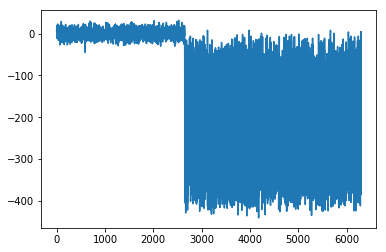

In [22]:
plt.plot(pipe.tracking_error)

### Run backtest with retraining on all available data

Next we run our backtest with retraining occurring at the end of every month. In this case when we retrain the pipeline we use all the available data at the time (i.e. our backtest framework is not peeking ahead).

In [32]:
pipe = pc.PipelineControl(data_path='examples/simple/data/varying_data.csv', 
                          prediction_path='examples/simple/data/predictions.csv',
                          retraining_flag=True)
pipe.runPipeline()

tdate=2008-08-28, pdate=2008-08-29, prediction=0, tracking_error=0
tdate=2008-08-29, pdate=2008-08-30, prediction=0, tracking_error=0
tdate=2008-08-30, pdate=2008-08-31, prediction=0, tracking_error=0
2008-08-31 00:00:00 rebuilding model....
model built
tdate=2008-08-31, pdate=2008-09-01, prediction=214.0, tracking_error=0
tdate=2008-09-01, pdate=2008-09-02, prediction=142.0, tracking_error=0
tdate=2008-09-02, pdate=2008-09-03, prediction=195.0, tracking_error=0
tdate=2008-09-03, pdate=2008-09-04, prediction=38.0, tracking_error=0
tdate=2008-09-04, pdate=2008-09-05, prediction=167.0, tracking_error=0
tdate=2008-09-05, pdate=2008-09-06, prediction=197.0, tracking_error=0
tdate=2008-09-06, pdate=2008-09-07, prediction=60.0, tracking_error=0
tdate=2008-09-07, pdate=2008-09-08, prediction=53.0, tracking_error=0
tdate=2008-09-08, pdate=2008-09-09, prediction=126.0, tracking_error=0
tdate=2008-09-09, pdate=2008-09-10, prediction=52.0, tracking_error=0
tdate=2008-09-10, pdate=2008-09-11, pred

tdate=2009-06-20, pdate=2009-06-21, prediction=90.0, tracking_error=0
tdate=2009-06-21, pdate=2009-06-22, prediction=194.0, tracking_error=0
tdate=2009-06-22, pdate=2009-06-23, prediction=238.0, tracking_error=0
tdate=2009-06-23, pdate=2009-06-24, prediction=213.0, tracking_error=0
tdate=2009-06-24, pdate=2009-06-25, prediction=167.0, tracking_error=0
tdate=2009-06-25, pdate=2009-06-26, prediction=186.0, tracking_error=0
tdate=2009-06-26, pdate=2009-06-27, prediction=271.0, tracking_error=0
tdate=2009-06-27, pdate=2009-06-28, prediction=187.0, tracking_error=0
tdate=2009-06-28, pdate=2009-06-29, prediction=80.0, tracking_error=0
tdate=2009-06-29, pdate=2009-06-30, prediction=76.0, tracking_error=0
2009-06-30 00:00:00 rebuilding model....
model built
tdate=2009-06-30, pdate=2009-07-01, prediction=136.0, tracking_error=0
tdate=2009-07-01, pdate=2009-07-02, prediction=73.0, tracking_error=0
tdate=2009-07-02, pdate=2009-07-03, prediction=241.0, tracking_error=0
tdate=2009-07-03, pdate=2009

model built
tdate=2010-01-31, pdate=2010-02-01, prediction=197.0, tracking_error=0
tdate=2010-02-01, pdate=2010-02-02, prediction=106.0, tracking_error=0
tdate=2010-02-02, pdate=2010-02-03, prediction=138.0, tracking_error=0
tdate=2010-02-03, pdate=2010-02-04, prediction=77.0, tracking_error=0
tdate=2010-02-04, pdate=2010-02-05, prediction=122.0, tracking_error=0
tdate=2010-02-05, pdate=2010-02-06, prediction=228.0, tracking_error=0
tdate=2010-02-06, pdate=2010-02-07, prediction=226.0, tracking_error=0
tdate=2010-02-07, pdate=2010-02-08, prediction=267.0, tracking_error=0
tdate=2010-02-08, pdate=2010-02-09, prediction=207.0, tracking_error=0
tdate=2010-02-09, pdate=2010-02-10, prediction=227.0, tracking_error=0
tdate=2010-02-10, pdate=2010-02-11, prediction=211.0, tracking_error=0
tdate=2010-02-11, pdate=2010-02-12, prediction=92.0, tracking_error=0
tdate=2010-02-12, pdate=2010-02-13, prediction=179.0, tracking_error=0
tdate=2010-02-13, pdate=2010-02-14, prediction=134.0, tracking_erro

model built
tdate=2010-12-31, pdate=2011-01-01, prediction=229.0, tracking_error=0
tdate=2011-01-01, pdate=2011-01-02, prediction=69.0, tracking_error=0
tdate=2011-01-02, pdate=2011-01-03, prediction=262.0, tracking_error=0
tdate=2011-01-03, pdate=2011-01-04, prediction=196.0, tracking_error=0
tdate=2011-01-04, pdate=2011-01-05, prediction=129.0, tracking_error=0
tdate=2011-01-05, pdate=2011-01-06, prediction=165.0, tracking_error=0
tdate=2011-01-06, pdate=2011-01-07, prediction=159.0, tracking_error=0
tdate=2011-01-07, pdate=2011-01-08, prediction=75.0, tracking_error=0
tdate=2011-01-08, pdate=2011-01-09, prediction=36.0, tracking_error=0
tdate=2011-01-09, pdate=2011-01-10, prediction=149.0, tracking_error=0
tdate=2011-01-10, pdate=2011-01-11, prediction=217.0, tracking_error=0
tdate=2011-01-11, pdate=2011-01-12, prediction=98.0, tracking_error=0
tdate=2011-01-12, pdate=2011-01-13, prediction=100.0, tracking_error=0
tdate=2011-01-13, pdate=2011-01-14, prediction=96.0, tracking_error=0

tdate=2011-10-03, pdate=2011-10-04, prediction=177.0, tracking_error=9.872034780483236
tdate=2011-10-04, pdate=2011-10-05, prediction=239.0, tracking_error=9.879275806034222
tdate=2011-10-05, pdate=2011-10-06, prediction=31.0, tracking_error=9.846312887486373
tdate=2011-10-06, pdate=2011-10-07, prediction=68.0, tracking_error=9.832411897959652
tdate=2011-10-07, pdate=2011-10-08, prediction=234.0, tracking_error=9.810884782098526
tdate=2011-10-08, pdate=2011-10-09, prediction=75.0, tracking_error=9.776864788218752
tdate=2011-10-09, pdate=2011-10-10, prediction=72.0, tracking_error=9.74254814083115
tdate=2011-10-10, pdate=2011-10-11, prediction=25.0, tracking_error=9.792421406487037
tdate=2011-10-11, pdate=2011-10-12, prediction=143.0, tracking_error=9.810643428939608
tdate=2011-10-12, pdate=2011-10-13, prediction=151.0, tracking_error=9.879766099466728
tdate=2011-10-13, pdate=2011-10-14, prediction=109.0, tracking_error=9.844919300055146
tdate=2011-10-14, pdate=2011-10-15, prediction=15

tdate=2012-04-30, pdate=2012-05-01, prediction=110.0, tracking_error=9.89688293262514
tdate=2012-05-01, pdate=2012-05-02, prediction=183.0, tracking_error=9.893665797050257
tdate=2012-05-02, pdate=2012-05-03, prediction=107.0, tracking_error=9.879349238371702
tdate=2012-05-03, pdate=2012-05-04, prediction=188.0, tracking_error=9.868269084271908
tdate=2012-05-04, pdate=2012-05-05, prediction=218.0, tracking_error=9.862654407052664
tdate=2012-05-05, pdate=2012-05-06, prediction=251.0, tracking_error=9.850401245835995
tdate=2012-05-06, pdate=2012-05-07, prediction=144.0, tracking_error=9.840386233044118
tdate=2012-05-07, pdate=2012-05-08, prediction=169.0, tracking_error=9.826687563703398
tdate=2012-05-08, pdate=2012-05-09, prediction=189.0, tracking_error=9.82810796249456
tdate=2012-05-09, pdate=2012-05-10, prediction=109.0, tracking_error=9.814861540004308
tdate=2012-05-10, pdate=2012-05-11, prediction=117.0, tracking_error=9.822716689973685
tdate=2012-05-11, pdate=2012-05-12, predictio

tdate=2012-11-11, pdate=2012-11-12, prediction=120.0, tracking_error=9.58087727689418
tdate=2012-11-12, pdate=2012-11-13, prediction=136.0, tracking_error=9.571980352367827
tdate=2012-11-13, pdate=2012-11-14, prediction=53.0, tracking_error=9.571543110206495
tdate=2012-11-14, pdate=2012-11-15, prediction=25.0, tracking_error=9.563368181448256
tdate=2012-11-15, pdate=2012-11-16, prediction=187.0, tracking_error=9.554794879336368
tdate=2012-11-16, pdate=2012-11-17, prediction=194.0, tracking_error=9.546019373887216
tdate=2012-11-17, pdate=2012-11-18, prediction=219.0, tracking_error=9.570744170053219
tdate=2012-11-18, pdate=2012-11-19, prediction=127.0, tracking_error=9.567151173102047
tdate=2012-11-19, pdate=2012-11-20, prediction=72.0, tracking_error=9.580931388730745
tdate=2012-11-20, pdate=2012-11-21, prediction=142.0, tracking_error=9.585157442312804
tdate=2012-11-21, pdate=2012-11-22, prediction=119.0, tracking_error=9.57643236858345
tdate=2012-11-22, pdate=2012-11-23, prediction=5

model built
tdate=2013-07-31, pdate=2013-08-01, prediction=227.0, tracking_error=10.095818825668267
tdate=2013-08-01, pdate=2013-08-02, prediction=112.0, tracking_error=10.091536057508787
tdate=2013-08-02, pdate=2013-08-03, prediction=161.0, tracking_error=10.086611847407328
tdate=2013-08-03, pdate=2013-08-04, prediction=137.0, tracking_error=10.08310564614256
tdate=2013-08-04, pdate=2013-08-05, prediction=149.0, tracking_error=10.081070060016431
tdate=2013-08-05, pdate=2013-08-06, prediction=171.0, tracking_error=10.07565009237816
tdate=2013-08-06, pdate=2013-08-07, prediction=171.0, tracking_error=10.069421162343689
tdate=2013-08-07, pdate=2013-08-08, prediction=277.0, tracking_error=10.069689026127882
tdate=2013-08-08, pdate=2013-08-09, prediction=168.0, tracking_error=10.065462150965523
tdate=2013-08-09, pdate=2013-08-10, prediction=239.0, tracking_error=10.060946761623457
tdate=2013-08-10, pdate=2013-08-11, prediction=185.0, tracking_error=10.061782981969685
tdate=2013-08-11, pdat

tdate=2014-03-02, pdate=2014-03-03, prediction=194.0, tracking_error=9.817521490493792
tdate=2014-03-03, pdate=2014-03-04, prediction=85.0, tracking_error=9.816848871619811
tdate=2014-03-04, pdate=2014-03-05, prediction=106.0, tracking_error=9.812495494265956
tdate=2014-03-05, pdate=2014-03-06, prediction=127.0, tracking_error=9.808147808367126
tdate=2014-03-06, pdate=2014-03-07, prediction=107.0, tracking_error=9.80661063611476
tdate=2014-03-07, pdate=2014-03-08, prediction=101.0, tracking_error=9.837972952006748
tdate=2014-03-08, pdate=2014-03-09, prediction=235.0, tracking_error=9.83486917241382
tdate=2014-03-09, pdate=2014-03-10, prediction=186.0, tracking_error=9.831914936898759
tdate=2014-03-10, pdate=2014-03-11, prediction=218.0, tracking_error=9.832992893047816
tdate=2014-03-11, pdate=2014-03-12, prediction=27.0, tracking_error=9.829895444582455
tdate=2014-03-12, pdate=2014-03-13, prediction=109.0, tracking_error=9.825153738538704
tdate=2014-03-13, pdate=2014-03-14, prediction=

tdate=2014-09-20, pdate=2014-09-21, prediction=98.0, tracking_error=9.78205612291736
tdate=2014-09-21, pdate=2014-09-22, prediction=168.0, tracking_error=9.798178601577648
tdate=2014-09-22, pdate=2014-09-23, prediction=203.0, tracking_error=9.795716929448687
tdate=2014-09-23, pdate=2014-09-24, prediction=101.0, tracking_error=9.813627800840587
tdate=2014-09-24, pdate=2014-09-25, prediction=158.0, tracking_error=9.81764271012817
tdate=2014-09-25, pdate=2014-09-26, prediction=66.0, tracking_error=9.814718638954364
tdate=2014-09-26, pdate=2014-09-27, prediction=81.0, tracking_error=9.81168730559231
tdate=2014-09-27, pdate=2014-09-28, prediction=27.0, tracking_error=9.833972010296186
tdate=2014-09-28, pdate=2014-09-29, prediction=34.0, tracking_error=9.83009848378656
tdate=2014-09-29, pdate=2014-09-30, prediction=107.0, tracking_error=9.828050339241942
2014-09-30 00:00:00 rebuilding model....
model built
tdate=2014-09-30, pdate=2014-10-01, prediction=52.0, tracking_error=9.824381980534886


tdate=2015-04-11, pdate=2015-04-12, prediction=163.0, tracking_error=9.918517083072246
tdate=2015-04-12, pdate=2015-04-13, prediction=67.0, tracking_error=9.915055842126357
tdate=2015-04-13, pdate=2015-04-14, prediction=133.0, tracking_error=9.921796246936392
tdate=2015-04-14, pdate=2015-04-15, prediction=120.0, tracking_error=9.92059033264804
tdate=2015-04-15, pdate=2015-04-16, prediction=78.0, tracking_error=9.925044041990054
tdate=2015-04-16, pdate=2015-04-17, prediction=141.0, tracking_error=9.921556106707815
tdate=2015-04-17, pdate=2015-04-18, prediction=183.0, tracking_error=9.920914644623478
tdate=2015-04-18, pdate=2015-04-19, prediction=136.0, tracking_error=9.928934161306687
tdate=2015-04-19, pdate=2015-04-20, prediction=91.0, tracking_error=9.926008872380255
tdate=2015-04-20, pdate=2015-04-21, prediction=159.0, tracking_error=9.922854631435312
tdate=2015-04-21, pdate=2015-04-22, prediction=76.0, tracking_error=9.920636985774488
tdate=2015-04-22, pdate=2015-04-23, prediction=1

tdate=2015-10-31, pdate=2015-11-01, prediction=216.0, tracking_error=10.029454790417104
tdate=2015-11-01, pdate=2015-11-02, prediction=173.0, tracking_error=10.027891259677222
tdate=2015-11-02, pdate=2015-11-03, prediction=119.0, tracking_error=10.026285122332787
tdate=2015-11-03, pdate=2015-11-04, prediction=100.0, tracking_error=10.035403773320082
tdate=2015-11-04, pdate=2015-11-05, prediction=265.0, tracking_error=10.03424479664779
tdate=2015-11-05, pdate=2015-11-06, prediction=48.0, tracking_error=10.04349243055631
tdate=2015-11-06, pdate=2015-11-07, prediction=28.0, tracking_error=10.043428247755948
tdate=2015-11-07, pdate=2015-11-08, prediction=217.0, tracking_error=10.044085027042032
tdate=2015-11-08, pdate=2015-11-09, prediction=81.0, tracking_error=10.04100175659102
tdate=2015-11-09, pdate=2015-11-10, prediction=104.0, tracking_error=10.037921323847133
tdate=2015-11-10, pdate=2015-11-11, prediction=214.0, tracking_error=10.037931549141478
tdate=2015-11-11, pdate=2015-11-12, pr

tdate=2016-05-20, pdate=2016-05-21, prediction=180.0, tracking_error=10.065491077948687
tdate=2016-05-21, pdate=2016-05-22, prediction=130.0, tracking_error=10.066615973765055
tdate=2016-05-22, pdate=2016-05-23, prediction=135.0, tracking_error=10.067735258028288
tdate=2016-05-23, pdate=2016-05-24, prediction=71.0, tracking_error=10.065427930744399
tdate=2016-05-24, pdate=2016-05-25, prediction=121.0, tracking_error=10.065426281784847
tdate=2016-05-25, pdate=2016-05-26, prediction=71.0, tracking_error=10.068832206530484
tdate=2016-05-26, pdate=2016-05-27, prediction=253.0, tracking_error=10.066182339374867
tdate=2016-05-27, pdate=2016-05-28, prediction=241.0, tracking_error=10.063877265170156
tdate=2016-05-28, pdate=2016-05-29, prediction=256.0, tracking_error=10.061793276110366
tdate=2016-05-29, pdate=2016-05-30, prediction=259.0, tracking_error=10.060759247214083
tdate=2016-05-30, pdate=2016-05-31, prediction=198.0, tracking_error=10.058014619453143
2016-05-31 00:00:00 rebuilding mod

tdate=2016-10-24, pdate=2016-10-25, prediction=129.0, tracking_error=10.048313793408676
tdate=2016-10-25, pdate=2016-10-26, prediction=118.0, tracking_error=10.056791954867215
tdate=2016-10-26, pdate=2016-10-27, prediction=118.0, tracking_error=10.054254698622103
tdate=2016-10-27, pdate=2016-10-28, prediction=154.0, tracking_error=10.052330708836928
tdate=2016-10-28, pdate=2016-10-29, prediction=156.0, tracking_error=10.057856891148816
tdate=2016-10-29, pdate=2016-10-30, prediction=222.0, tracking_error=10.069822342311856
tdate=2016-10-30, pdate=2016-10-31, prediction=134.0, tracking_error=10.067674643260595
2016-10-31 00:00:00 rebuilding model....
model built
tdate=2016-10-31, pdate=2016-11-01, prediction=148.0, tracking_error=10.06523469874964
tdate=2016-11-01, pdate=2016-11-02, prediction=20.0, tracking_error=10.064276137533192
tdate=2016-11-02, pdate=2016-11-03, prediction=97.0, tracking_error=10.061839052981519
tdate=2016-11-03, pdate=2016-11-04, prediction=41.0, tracking_error=10

tdate=2017-04-13, pdate=2017-04-14, prediction=134.0, tracking_error=10.085349423464246
tdate=2017-04-14, pdate=2017-04-15, prediction=138.0, tracking_error=10.086357026050802
tdate=2017-04-15, pdate=2017-04-16, prediction=190.0, tracking_error=10.104789921548509
tdate=2017-04-16, pdate=2017-04-17, prediction=225.0, tracking_error=10.103282900191088
tdate=2017-04-17, pdate=2017-04-18, prediction=207.0, tracking_error=10.10152186389308
tdate=2017-04-18, pdate=2017-04-19, prediction=209.0, tracking_error=10.0992036934566
tdate=2017-04-19, pdate=2017-04-20, prediction=168.0, tracking_error=10.098705280431762
tdate=2017-04-20, pdate=2017-04-21, prediction=40.0, tracking_error=10.0964531004511
tdate=2017-04-21, pdate=2017-04-22, prediction=135.0, tracking_error=10.101577537597647
tdate=2017-04-22, pdate=2017-04-23, prediction=75.0, tracking_error=10.099803743899924
tdate=2017-04-23, pdate=2017-04-24, prediction=114.0, tracking_error=10.098301339967286
tdate=2017-04-24, pdate=2017-04-25, pre

tdate=2017-10-31, pdate=2017-11-01, prediction=89.0, tracking_error=9.992702597646304
tdate=2017-11-01, pdate=2017-11-02, prediction=209.0, tracking_error=9.99405992588268
tdate=2017-11-02, pdate=2017-11-03, prediction=96.0, tracking_error=9.996225788835925
tdate=2017-11-03, pdate=2017-11-04, prediction=221.0, tracking_error=9.994116723561111
tdate=2017-11-04, pdate=2017-11-05, prediction=225.0, tracking_error=9.993793446295987
tdate=2017-11-05, pdate=2017-11-06, prediction=186.0, tracking_error=9.991674038292617
tdate=2017-11-06, pdate=2017-11-07, prediction=137.0, tracking_error=9.99012862025843
tdate=2017-11-07, pdate=2017-11-08, prediction=194.0, tracking_error=9.989804899564458
tdate=2017-11-08, pdate=2017-11-09, prediction=172.0, tracking_error=9.993246417747057
tdate=2017-11-09, pdate=2017-11-10, prediction=176.0, tracking_error=9.992917562398336
tdate=2017-11-10, pdate=2017-11-11, prediction=139.0, tracking_error=9.994844956769104
tdate=2017-11-11, pdate=2017-11-12, prediction=

tdate=2018-05-22, pdate=2018-05-23, prediction=71.0, tracking_error=10.019894472468764
tdate=2018-05-23, pdate=2018-05-24, prediction=187.0, tracking_error=10.024375989443348
tdate=2018-05-24, pdate=2018-05-25, prediction=158.0, tracking_error=10.025148162868678
tdate=2018-05-25, pdate=2018-05-26, prediction=199.0, tracking_error=10.023526882770284
tdate=2018-05-26, pdate=2018-05-27, prediction=56.0, tracking_error=10.021763477048799
tdate=2018-05-27, pdate=2018-05-28, prediction=106.0, tracking_error=10.02318198445513
tdate=2018-05-28, pdate=2018-05-29, prediction=206.0, tracking_error=10.021315680230769
tdate=2018-05-29, pdate=2018-05-30, prediction=82.0, tracking_error=10.020881802172953
tdate=2018-05-30, pdate=2018-05-31, prediction=185.0, tracking_error=10.019213464226635
2018-05-31 00:00:00 rebuilding model....
model built
tdate=2018-05-31, pdate=2018-06-01, prediction=255.0, tracking_error=10.01816901369452
tdate=2018-06-01, pdate=2018-06-02, prediction=85.0, tracking_error=10.0

tdate=2018-11-25, pdate=2018-11-26, prediction=250.0, tracking_error=44.35028971368451
tdate=2018-11-26, pdate=2018-11-27, prediction=126.0, tracking_error=44.83490273683546
tdate=2018-11-27, pdate=2018-11-28, prediction=141.0, tracking_error=44.911025481949174
tdate=2018-11-28, pdate=2018-11-29, prediction=116.0, tracking_error=45.16379279248137
tdate=2018-11-29, pdate=2018-11-30, prediction=133.0, tracking_error=45.35192813852367
2018-11-30 00:00:00 rebuilding model....
model built
tdate=2018-11-30, pdate=2018-12-01, prediction=121.0, tracking_error=45.61178858470613
tdate=2018-12-01, pdate=2018-12-02, prediction=173.0, tracking_error=45.71830662940344
tdate=2018-12-02, pdate=2018-12-03, prediction=188.0, tracking_error=45.854438624126
tdate=2018-12-03, pdate=2018-12-04, prediction=23.0, tracking_error=46.100449750947874
tdate=2018-12-04, pdate=2018-12-05, prediction=137.0, tracking_error=46.092095844678276
tdate=2018-12-05, pdate=2018-12-06, prediction=172.0, tracking_error=46.37130

tdate=2019-06-21, pdate=2019-06-22, prediction=211.0, tracking_error=72.63764300780545
tdate=2019-06-22, pdate=2019-06-23, prediction=190.0, tracking_error=72.85343533962939
tdate=2019-06-23, pdate=2019-06-24, prediction=146.0, tracking_error=72.99076364795373
tdate=2019-06-24, pdate=2019-06-25, prediction=164.0, tracking_error=73.16364882653592
tdate=2019-06-25, pdate=2019-06-26, prediction=241.0, tracking_error=73.32433033271852
tdate=2019-06-26, pdate=2019-06-27, prediction=168.0, tracking_error=73.58698518226336
tdate=2019-06-27, pdate=2019-06-28, prediction=70.0, tracking_error=73.67725614987263
tdate=2019-06-28, pdate=2019-06-29, prediction=68.0, tracking_error=73.69077680565756
tdate=2019-06-29, pdate=2019-06-30, prediction=124.0, tracking_error=73.68325247460633
2019-06-30 00:00:00 rebuilding model....
model built
tdate=2019-06-30, pdate=2019-07-01, prediction=63.0, tracking_error=73.69121451915976
tdate=2019-07-01, pdate=2019-07-02, prediction=210.0, tracking_error=73.70615575

model built
tdate=2019-12-31, pdate=2020-01-01, prediction=217.0, tracking_error=85.7155127284229
tdate=2020-01-01, pdate=2020-01-02, prediction=220.0, tracking_error=85.88385706861087
tdate=2020-01-02, pdate=2020-01-03, prediction=104.0, tracking_error=86.08423425860002
tdate=2020-01-03, pdate=2020-01-04, prediction=94.0, tracking_error=86.09503020637538
tdate=2020-01-04, pdate=2020-01-05, prediction=69.0, tracking_error=86.11654622692846
tdate=2020-01-05, pdate=2020-01-06, prediction=65.0, tracking_error=86.10846215850903
tdate=2020-01-06, pdate=2020-01-07, prediction=100.0, tracking_error=86.09560685101324
tdate=2020-01-07, pdate=2020-01-08, prediction=86.0, tracking_error=86.10806539504357
tdate=2020-01-08, pdate=2020-01-09, prediction=111.0, tracking_error=86.119198844303
tdate=2020-01-09, pdate=2020-01-10, prediction=120.0, tracking_error=86.16517607970628
tdate=2020-01-10, pdate=2020-01-11, prediction=106.0, tracking_error=86.1770973046917
tdate=2020-01-11, pdate=2020-01-12, pre

tdate=2020-06-13, pdate=2020-06-14, prediction=121.0, tracking_error=94.41147993647144
tdate=2020-06-14, pdate=2020-06-15, prediction=152.0, tracking_error=94.43302936357506
tdate=2020-06-15, pdate=2020-06-16, prediction=181.0, tracking_error=94.55933542804966
tdate=2020-06-16, pdate=2020-06-17, prediction=90.0, tracking_error=94.66880951772141
tdate=2020-06-17, pdate=2020-06-18, prediction=116.0, tracking_error=94.69655931396296
tdate=2020-06-18, pdate=2020-06-19, prediction=129.0, tracking_error=94.70770306123171
tdate=2020-06-19, pdate=2020-06-20, prediction=121.0, tracking_error=94.77860047788941
tdate=2020-06-20, pdate=2020-06-21, prediction=131.0, tracking_error=94.82007398526837
tdate=2020-06-21, pdate=2020-06-22, prediction=195.0, tracking_error=94.861470760426
tdate=2020-06-22, pdate=2020-06-23, prediction=52.0, tracking_error=94.9656221854044
tdate=2020-06-23, pdate=2020-06-24, prediction=157.0, tracking_error=94.95703130697005
tdate=2020-06-24, pdate=2020-06-25, prediction=9

tdate=2020-10-30, pdate=2020-10-31, prediction=86.0, tracking_error=98.61826536511889
2020-10-31 00:00:00 rebuilding model....
model built
tdate=2020-10-31, pdate=2020-11-01, prediction=104.0, tracking_error=98.60489571000497
tdate=2020-11-01, pdate=2020-11-02, prediction=114.0, tracking_error=98.6064453325909
tdate=2020-11-02, pdate=2020-11-03, prediction=94.0, tracking_error=98.60151048637813
tdate=2020-11-03, pdate=2020-11-04, prediction=41.0, tracking_error=98.59959693922069
tdate=2020-11-04, pdate=2020-11-05, prediction=95.0, tracking_error=98.58534095083986
tdate=2020-11-05, pdate=2020-11-06, prediction=108.0, tracking_error=98.57800540744374
tdate=2020-11-06, pdate=2020-11-07, prediction=169.0, tracking_error=98.60071995616205
tdate=2020-11-07, pdate=2020-11-08, prediction=95.0, tracking_error=98.69711148864545
tdate=2020-11-08, pdate=2020-11-09, prediction=66.0, tracking_error=98.69917493414293
tdate=2020-11-09, pdate=2020-11-10, prediction=63.0, tracking_error=98.6891036853197

tdate=2021-03-28, pdate=2021-03-29, prediction=140.0, tracking_error=101.2793058837007
tdate=2021-03-29, pdate=2021-03-30, prediction=27.0, tracking_error=101.36429943884966
tdate=2021-03-30, pdate=2021-03-31, prediction=151.0, tracking_error=101.35155672532308
2021-03-31 00:00:00 rebuilding model....
model built
tdate=2021-03-31, pdate=2021-04-01, prediction=173.0, tracking_error=101.4006274179026
tdate=2021-04-01, pdate=2021-04-02, prediction=134.0, tracking_error=101.4912905917164
tdate=2021-04-02, pdate=2021-04-03, prediction=98.0, tracking_error=101.50421764493878
tdate=2021-04-03, pdate=2021-04-04, prediction=140.0, tracking_error=101.52319077081418
tdate=2021-04-04, pdate=2021-04-05, prediction=49.0, tracking_error=101.55971931135059
tdate=2021-04-05, pdate=2021-04-06, prediction=94.0, tracking_error=101.54564443457633
tdate=2021-04-06, pdate=2021-04-07, prediction=133.0, tracking_error=101.54673474425665
tdate=2021-04-07, pdate=2021-04-08, prediction=73.0, tracking_error=101.60

tdate=2021-09-01, pdate=2021-09-02, prediction=63.0, tracking_error=104.22950534626872
tdate=2021-09-02, pdate=2021-09-03, prediction=67.0, tracking_error=104.22231871355397
tdate=2021-09-03, pdate=2021-09-04, prediction=83.0, tracking_error=104.21550677016337
tdate=2021-09-04, pdate=2021-09-05, prediction=172.0, tracking_error=104.20177726725619
tdate=2021-09-05, pdate=2021-09-06, prediction=164.0, tracking_error=104.26856258777892
tdate=2021-09-06, pdate=2021-09-07, prediction=163.0, tracking_error=104.30637311381398
tdate=2021-09-07, pdate=2021-09-08, prediction=114.0, tracking_error=104.33624138172254
tdate=2021-09-08, pdate=2021-09-09, prediction=104.0, tracking_error=104.38081444615491
tdate=2021-09-09, pdate=2021-09-10, prediction=54.0, tracking_error=104.37491135387332
tdate=2021-09-10, pdate=2021-09-11, prediction=117.0, tracking_error=104.3711485196726
tdate=2021-09-11, pdate=2021-09-12, prediction=81.0, tracking_error=104.38016413018828
tdate=2021-09-12, pdate=2021-09-13, pr

tdate=2022-02-21, pdate=2022-02-22, prediction=135.0, tracking_error=105.74088549697825
tdate=2022-02-22, pdate=2022-02-23, prediction=62.0, tracking_error=105.77358013857446
tdate=2022-02-23, pdate=2022-02-24, prediction=134.0, tracking_error=105.76011595505494
tdate=2022-02-24, pdate=2022-02-25, prediction=91.0, tracking_error=105.77622311817919
tdate=2022-02-25, pdate=2022-02-26, prediction=145.0, tracking_error=105.790086536823
tdate=2022-02-26, pdate=2022-02-27, prediction=85.0, tracking_error=105.84396076301257
tdate=2022-02-27, pdate=2022-02-28, prediction=60.0, tracking_error=105.84628588519955
2022-02-28 00:00:00 rebuilding model....
model built
tdate=2022-02-28, pdate=2022-03-01, prediction=128.0, tracking_error=105.84622191880797
tdate=2022-03-01, pdate=2022-03-02, prediction=143.0, tracking_error=105.88752257508528
tdate=2022-03-02, pdate=2022-03-03, prediction=130.0, tracking_error=105.95926565226607
tdate=2022-03-03, pdate=2022-03-04, prediction=168.0, tracking_error=105.

tdate=2022-07-20, pdate=2022-07-21, prediction=36.0, tracking_error=106.5804790071145
tdate=2022-07-21, pdate=2022-07-22, prediction=124.0, tracking_error=106.56752710269704
tdate=2022-07-22, pdate=2022-07-23, prediction=43.0, tracking_error=106.61338815531998
tdate=2022-07-23, pdate=2022-07-24, prediction=86.0, tracking_error=106.6004890473557
tdate=2022-07-24, pdate=2022-07-25, prediction=89.0, tracking_error=106.58742466245108
tdate=2022-07-25, pdate=2022-07-26, prediction=141.0, tracking_error=106.57503937651639
tdate=2022-07-26, pdate=2022-07-27, prediction=118.0, tracking_error=106.59769172587599
tdate=2022-07-27, pdate=2022-07-28, prediction=123.0, tracking_error=106.62362269734935
tdate=2022-07-28, pdate=2022-07-29, prediction=70.0, tracking_error=106.64825728441575
tdate=2022-07-29, pdate=2022-07-30, prediction=119.0, tracking_error=106.63604517767881
tdate=2022-07-30, pdate=2022-07-31, prediction=51.0, tracking_error=106.64650268871067
2022-07-31 00:00:00 rebuilding model....

tdate=2022-11-11, pdate=2022-11-12, prediction=60.0, tracking_error=107.13272634364495
tdate=2022-11-12, pdate=2022-11-13, prediction=29.0, tracking_error=107.13814870260961
tdate=2022-11-13, pdate=2022-11-14, prediction=20.0, tracking_error=107.1255589937568
tdate=2022-11-14, pdate=2022-11-15, prediction=110.0, tracking_error=107.11667744654284
tdate=2022-11-15, pdate=2022-11-16, prediction=84.0, tracking_error=107.11833078400547
tdate=2022-11-16, pdate=2022-11-17, prediction=120.0, tracking_error=107.14234345071732
tdate=2022-11-17, pdate=2022-11-18, prediction=85.0, tracking_error=107.16315884251327
tdate=2022-11-18, pdate=2022-11-19, prediction=44.0, tracking_error=107.15197196719255
tdate=2022-11-19, pdate=2022-11-20, prediction=68.0, tracking_error=107.13940163241705
tdate=2022-11-20, pdate=2022-11-21, prediction=73.0, tracking_error=107.1405162854077
tdate=2022-11-21, pdate=2022-11-22, prediction=28.0, tracking_error=107.1288055287356
tdate=2022-11-22, pdate=2022-11-23, predicti

tdate=2023-04-20, pdate=2023-04-21, prediction=68.0, tracking_error=107.33378835853343
tdate=2023-04-21, pdate=2023-04-22, prediction=76.0, tracking_error=107.32516733805065
tdate=2023-04-22, pdate=2023-04-23, prediction=98.0, tracking_error=107.31311059916439
tdate=2023-04-23, pdate=2023-04-24, prediction=95.0, tracking_error=107.33167968213786
tdate=2023-04-24, pdate=2023-04-25, prediction=83.0, tracking_error=107.32257195251336
tdate=2023-04-25, pdate=2023-04-26, prediction=56.0, tracking_error=107.34485034734719
tdate=2023-04-26, pdate=2023-04-27, prediction=61.0, tracking_error=107.33715757414318
tdate=2023-04-27, pdate=2023-04-28, prediction=38.0, tracking_error=107.33072304039706
tdate=2023-04-28, pdate=2023-04-29, prediction=57.0, tracking_error=107.31962786886125
tdate=2023-04-29, pdate=2023-04-30, prediction=43.0, tracking_error=107.30814088598427
2023-04-30 00:00:00 rebuilding model....
model built
tdate=2023-04-30, pdate=2023-05-01, prediction=77.0, tracking_error=107.29596

tdate=2023-10-03, pdate=2023-10-04, prediction=96.0, tracking_error=107.43962739112749
tdate=2023-10-04, pdate=2023-10-05, prediction=22.0, tracking_error=107.44460803307175
tdate=2023-10-05, pdate=2023-10-06, prediction=83.0, tracking_error=107.43283964018966
tdate=2023-10-06, pdate=2023-10-07, prediction=91.0, tracking_error=107.45889679034268
tdate=2023-10-07, pdate=2023-10-08, prediction=66.0, tracking_error=107.45608686139465
tdate=2023-10-08, pdate=2023-10-09, prediction=80.0, tracking_error=107.44428092802747
tdate=2023-10-09, pdate=2023-10-10, prediction=79.0, tracking_error=107.4354103967242
tdate=2023-10-10, pdate=2023-10-11, prediction=66.0, tracking_error=107.42407938263403
tdate=2023-10-11, pdate=2023-10-12, prediction=77.0, tracking_error=107.41338665970493
tdate=2023-10-12, pdate=2023-10-13, prediction=45.0, tracking_error=107.40775821826168
tdate=2023-10-13, pdate=2023-10-14, prediction=63.0, tracking_error=107.4065670207685
tdate=2023-10-14, pdate=2023-10-15, predictio

tdate=2024-02-23, pdate=2024-02-24, prediction=96.0, tracking_error=106.98912858897653
tdate=2024-02-24, pdate=2024-02-25, prediction=113.0, tracking_error=106.98441846176199
tdate=2024-02-25, pdate=2024-02-26, prediction=53.0, tracking_error=106.9807319181388
tdate=2024-02-26, pdate=2024-02-27, prediction=52.0, tracking_error=106.97054462989514
tdate=2024-02-27, pdate=2024-02-28, prediction=77.0, tracking_error=106.96045463030535
tdate=2024-02-28, pdate=2024-02-29, prediction=68.0, tracking_error=106.94918529450196
2024-02-29 00:00:00 rebuilding model....
model built
tdate=2024-02-29, pdate=2024-03-01, prediction=85.0, tracking_error=106.94448046328516
tdate=2024-03-01, pdate=2024-03-02, prediction=41.0, tracking_error=106.95077329202529
tdate=2024-03-02, pdate=2024-03-03, prediction=55.0, tracking_error=106.93939477412304
tdate=2024-03-03, pdate=2024-03-04, prediction=74.0, tracking_error=106.92830209500025
tdate=2024-03-04, pdate=2024-03-05, prediction=57.0, tracking_error=106.91733

model built
tdate=2024-07-31, pdate=2024-08-01, prediction=32.0, tracking_error=106.78475411809299
tdate=2024-08-01, pdate=2024-08-02, prediction=28.0, tracking_error=106.77389208732785
tdate=2024-08-02, pdate=2024-08-03, prediction=101.0, tracking_error=106.76843353018394
tdate=2024-08-03, pdate=2024-08-04, prediction=69.0, tracking_error=106.77401719643854
tdate=2024-08-04, pdate=2024-08-05, prediction=112.0, tracking_error=106.78141894066341
tdate=2024-08-05, pdate=2024-08-06, prediction=40.0, tracking_error=106.79771530270247
tdate=2024-08-06, pdate=2024-08-07, prediction=49.0, tracking_error=106.79593929883289
tdate=2024-08-07, pdate=2024-08-08, prediction=66.0, tracking_error=106.78920588621745
tdate=2024-08-08, pdate=2024-08-09, prediction=95.0, tracking_error=106.80109834221533
tdate=2024-08-09, pdate=2024-08-10, prediction=85.0, tracking_error=106.803953331005
tdate=2024-08-10, pdate=2024-08-11, prediction=36.0, tracking_error=106.79761105990838
tdate=2024-08-11, pdate=2024-08

tdate=2025-01-01, pdate=2025-01-02, prediction=69.0, tracking_error=106.50566564669201
tdate=2025-01-02, pdate=2025-01-03, prediction=78.0, tracking_error=106.49569827721174
tdate=2025-01-03, pdate=2025-01-04, prediction=35.0, tracking_error=106.48862621563525
tdate=2025-01-04, pdate=2025-01-05, prediction=36.0, tracking_error=106.4809930155924
tdate=2025-01-05, pdate=2025-01-06, prediction=67.0, tracking_error=106.47416093187974
tdate=2025-01-06, pdate=2025-01-07, prediction=47.0, tracking_error=106.46489866643101
tdate=2025-01-07, pdate=2025-01-08, prediction=86.0, tracking_error=106.45522890424976
tdate=2025-01-08, pdate=2025-01-09, prediction=48.0, tracking_error=106.44453678452547
tdate=2025-01-09, pdate=2025-01-10, prediction=77.0, tracking_error=106.43434492280169
tdate=2025-01-10, pdate=2025-01-11, prediction=45.0, tracking_error=106.42776339048606
tdate=2025-01-11, pdate=2025-01-12, prediction=102.0, tracking_error=106.42829217099491
tdate=2025-01-12, pdate=2025-01-13, predict

tdate=2025-06-17, pdate=2025-06-18, prediction=36.0, tracking_error=105.78693662073377
tdate=2025-06-18, pdate=2025-06-19, prediction=53.0, tracking_error=105.78357930656286
tdate=2025-06-19, pdate=2025-06-20, prediction=75.0, tracking_error=105.77355970523361
tdate=2025-06-20, pdate=2025-06-21, prediction=29.0, tracking_error=105.76555495305395
tdate=2025-06-21, pdate=2025-06-22, prediction=44.0, tracking_error=105.76060457372394
tdate=2025-06-22, pdate=2025-06-23, prediction=55.0, tracking_error=105.7536490162031
tdate=2025-06-23, pdate=2025-06-24, prediction=51.0, tracking_error=105.74399773010869
tdate=2025-06-24, pdate=2025-06-25, prediction=84.0, tracking_error=105.73372832811677
tdate=2025-06-25, pdate=2025-06-26, prediction=98.0, tracking_error=105.7432682785505
tdate=2025-06-26, pdate=2025-06-27, prediction=102.0, tracking_error=105.75764603596626
tdate=2025-06-27, pdate=2025-06-28, prediction=86.0, tracking_error=105.77353335437986
tdate=2025-06-28, pdate=2025-06-29, predicti

tdate=2025-11-15, pdate=2025-11-16, prediction=103.0, tracking_error=105.25671946548252
tdate=2025-11-16, pdate=2025-11-17, prediction=71.0, tracking_error=105.26738930893106
tdate=2025-11-17, pdate=2025-11-18, prediction=50.0, tracking_error=105.27004862945067
tdate=2025-11-18, pdate=2025-11-19, prediction=31.0, tracking_error=105.28069669339291
tdate=2025-11-19, pdate=2025-11-20, prediction=65.0, tracking_error=105.27586032618969
tdate=2025-11-20, pdate=2025-11-21, prediction=47.0, tracking_error=105.27705897335412
tdate=2025-11-21, pdate=2025-11-22, prediction=35.0, tracking_error=105.2671994587698
tdate=2025-11-22, pdate=2025-11-23, prediction=76.0, tracking_error=105.27395183357687
tdate=2025-11-23, pdate=2025-11-24, prediction=14.0, tracking_error=105.26401438302763
tdate=2025-11-24, pdate=2025-11-25, prediction=48.0, tracking_error=105.25947690558617
tdate=2025-11-25, pdate=2025-11-26, prediction=37.0, tracking_error=105.2496266677749
tdate=2025-11-26, pdate=2025-11-27, predicti

tdate=2026-04-16, pdate=2026-04-17, prediction=52.0, tracking_error=104.76025159296057
tdate=2026-04-17, pdate=2026-04-18, prediction=28.0, tracking_error=104.75066848558706
tdate=2026-04-18, pdate=2026-04-19, prediction=29.0, tracking_error=104.74266383107759
tdate=2026-04-19, pdate=2026-04-20, prediction=84.0, tracking_error=104.73306572155641
tdate=2026-04-20, pdate=2026-04-21, prediction=72.0, tracking_error=104.73055632760077
tdate=2026-04-21, pdate=2026-04-22, prediction=52.0, tracking_error=104.72119293735774
tdate=2026-04-22, pdate=2026-04-23, prediction=33.0, tracking_error=104.71183405833982
tdate=2026-04-23, pdate=2026-04-24, prediction=87.0, tracking_error=104.71614286974716
tdate=2026-04-24, pdate=2026-04-25, prediction=84.0, tracking_error=104.70760746130216
tdate=2026-04-25, pdate=2026-04-26, prediction=52.0, tracking_error=104.69889799568884
tdate=2026-04-26, pdate=2026-04-27, prediction=48.0, tracking_error=104.69422203696875
tdate=2026-04-27, pdate=2026-04-28, predict

tdate=2026-10-13, pdate=2026-10-14, prediction=80.0, tracking_error=104.00619939120566
tdate=2026-10-14, pdate=2026-10-15, prediction=54.0, tracking_error=104.01689170625225
tdate=2026-10-15, pdate=2026-10-16, prediction=10.0, tracking_error=104.0077591102981
tdate=2026-10-16, pdate=2026-10-17, prediction=86.0, tracking_error=103.99851199823031
tdate=2026-10-17, pdate=2026-10-18, prediction=22.0, tracking_error=103.99881523564476
tdate=2026-10-18, pdate=2026-10-19, prediction=29.0, tracking_error=103.99105662081259
tdate=2026-10-19, pdate=2026-10-20, prediction=55.0, tracking_error=103.98645323266642
tdate=2026-10-20, pdate=2026-10-21, prediction=51.0, tracking_error=103.9774516352613
tdate=2026-10-21, pdate=2026-10-22, prediction=68.0, tracking_error=103.98127632132422
tdate=2026-10-22, pdate=2026-10-23, prediction=14.0, tracking_error=103.9727777290141
tdate=2026-10-23, pdate=2026-10-24, prediction=65.0, tracking_error=103.9670821777456
tdate=2026-10-24, pdate=2026-10-25, prediction=

tdate=2027-04-07, pdate=2027-04-08, prediction=77.0, tracking_error=103.21525652987803
tdate=2027-04-08, pdate=2027-04-09, prediction=57.0, tracking_error=103.21952558330108
tdate=2027-04-09, pdate=2027-04-10, prediction=74.0, tracking_error=103.21227643899944
tdate=2027-04-10, pdate=2027-04-11, prediction=11.0, tracking_error=103.21782985914953
tdate=2027-04-11, pdate=2027-04-12, prediction=66.0, tracking_error=103.21004684898264
tdate=2027-04-12, pdate=2027-04-13, prediction=57.0, tracking_error=103.20280400405409
tdate=2027-04-13, pdate=2027-04-14, prediction=57.0, tracking_error=103.19416786377344
tdate=2027-04-14, pdate=2027-04-15, prediction=75.0, tracking_error=103.18658150573089
tdate=2027-04-15, pdate=2027-04-16, prediction=70.0, tracking_error=103.18026585327817
tdate=2027-04-16, pdate=2027-04-17, prediction=55.0, tracking_error=103.1796430471559
tdate=2027-04-17, pdate=2027-04-18, prediction=36.0, tracking_error=103.17789634098706
tdate=2027-04-18, pdate=2027-04-19, predicti

tdate=2027-09-08, pdate=2027-09-09, prediction=75.0, tracking_error=102.38988507144069
tdate=2027-09-09, pdate=2027-09-10, prediction=81.0, tracking_error=102.38128703811758
tdate=2027-09-10, pdate=2027-09-11, prediction=30.0, tracking_error=102.38695734010797
tdate=2027-09-11, pdate=2027-09-12, prediction=36.0, tracking_error=102.38170488376562
tdate=2027-09-12, pdate=2027-09-13, prediction=54.0, tracking_error=102.3808020353907
tdate=2027-09-13, pdate=2027-09-14, prediction=56.0, tracking_error=102.37281136486563
tdate=2027-09-14, pdate=2027-09-15, prediction=48.0, tracking_error=102.37012089623845
tdate=2027-09-15, pdate=2027-09-16, prediction=49.0, tracking_error=102.36575978038665
tdate=2027-09-16, pdate=2027-09-17, prediction=37.0, tracking_error=102.35725508028726
tdate=2027-09-17, pdate=2027-09-18, prediction=29.0, tracking_error=102.35767312463123
tdate=2027-09-18, pdate=2027-09-19, prediction=79.0, tracking_error=102.3555497629332
tdate=2027-09-19, pdate=2027-09-20, predictio

tdate=2028-02-08, pdate=2028-02-09, prediction=56.0, tracking_error=101.59047575028944
tdate=2028-02-09, pdate=2028-02-10, prediction=59.0, tracking_error=101.58755020531856
tdate=2028-02-10, pdate=2028-02-11, prediction=15.0, tracking_error=101.5802640017194
tdate=2028-02-11, pdate=2028-02-12, prediction=54.0, tracking_error=101.5765055441432
tdate=2028-02-12, pdate=2028-02-13, prediction=17.0, tracking_error=101.56905726284512
tdate=2028-02-13, pdate=2028-02-14, prediction=49.0, tracking_error=101.56075808471378
tdate=2028-02-14, pdate=2028-02-15, prediction=10.0, tracking_error=101.55333486480771
tdate=2028-02-15, pdate=2028-02-16, prediction=38.0, tracking_error=101.54580949099717
tdate=2028-02-16, pdate=2028-02-17, prediction=66.0, tracking_error=101.53926705353811
tdate=2028-02-17, pdate=2028-02-18, prediction=54.0, tracking_error=101.54092073240619
tdate=2028-02-18, pdate=2028-02-19, prediction=55.0, tracking_error=101.53506850985946
tdate=2028-02-19, pdate=2028-02-20, predictio

tdate=2028-07-02, pdate=2028-07-03, prediction=68.0, tracking_error=100.87620795545514
tdate=2028-07-03, pdate=2028-07-04, prediction=54.0, tracking_error=100.86951670649364
tdate=2028-07-04, pdate=2028-07-05, prediction=44.0, tracking_error=100.86156812625215
tdate=2028-07-05, pdate=2028-07-06, prediction=28.0, tracking_error=100.85494699217709
tdate=2028-07-06, pdate=2028-07-07, prediction=14.0, tracking_error=100.84740545427792
tdate=2028-07-07, pdate=2028-07-08, prediction=16.0, tracking_error=100.83938487835402
tdate=2028-07-08, pdate=2028-07-09, prediction=1.0, tracking_error=100.84306089352467
tdate=2028-07-09, pdate=2028-07-10, prediction=3.0, tracking_error=100.83644376042929
tdate=2028-07-10, pdate=2028-07-11, prediction=63.0, tracking_error=100.83341425467839
tdate=2028-07-11, pdate=2028-07-12, prediction=38.0, tracking_error=100.82705966073995
tdate=2028-07-12, pdate=2028-07-13, prediction=34.0, tracking_error=100.81922460541448
tdate=2028-07-13, pdate=2028-07-14, predictio

In this case we see that the error starts to get smaller as the model is refitting, however it is very slowly getting back to the expected error.

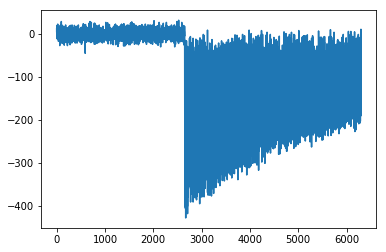

In [26]:
plt.plot(pipe.tracking_error)

### Run backtest with retraining on a sliding window

Next we run our backtest with retraining occurring at the end of every month. In this case when we retrain the pipeline we use the most recent 500 datapoints rather than the entire history.

In [27]:
pipe = pc.PipelineControl(data_path='examples/simple/data/varying_data.csv', 
                          prediction_path='examples/simple/data/predictions.csv',
                          retraining_flag=True,
                          sliding_window_size=500)
pipe.runPipeline()

tdate=2010-01-10, pdate=2010-01-11, prediction=0, tracking_error=0
tdate=2010-01-11, pdate=2010-01-12, prediction=0, tracking_error=0
tdate=2010-01-12, pdate=2010-01-13, prediction=0, tracking_error=0
tdate=2010-01-13, pdate=2010-01-14, prediction=0, tracking_error=0
tdate=2010-01-14, pdate=2010-01-15, prediction=0, tracking_error=0
tdate=2010-01-15, pdate=2010-01-16, prediction=0, tracking_error=0
tdate=2010-01-16, pdate=2010-01-17, prediction=0, tracking_error=0
tdate=2010-01-17, pdate=2010-01-18, prediction=0, tracking_error=0
tdate=2010-01-18, pdate=2010-01-19, prediction=0, tracking_error=0
tdate=2010-01-19, pdate=2010-01-20, prediction=0, tracking_error=0
tdate=2010-01-20, pdate=2010-01-21, prediction=0, tracking_error=0
tdate=2010-01-21, pdate=2010-01-22, prediction=0, tracking_error=0
tdate=2010-01-22, pdate=2010-01-23, prediction=0, tracking_error=0
tdate=2010-01-23, pdate=2010-01-24, prediction=0, tracking_error=0
tdate=2010-01-24, pdate=2010-01-25, prediction=0, tracking_err

tdate=2010-10-19, pdate=2010-10-20, prediction=141.0, tracking_error=0
tdate=2010-10-20, pdate=2010-10-21, prediction=198.0, tracking_error=0
tdate=2010-10-21, pdate=2010-10-22, prediction=210.0, tracking_error=0
tdate=2010-10-22, pdate=2010-10-23, prediction=98.0, tracking_error=0
tdate=2010-10-23, pdate=2010-10-24, prediction=124.0, tracking_error=0
tdate=2010-10-24, pdate=2010-10-25, prediction=216.0, tracking_error=0
tdate=2010-10-25, pdate=2010-10-26, prediction=202.0, tracking_error=0
tdate=2010-10-26, pdate=2010-10-27, prediction=81.0, tracking_error=0
tdate=2010-10-27, pdate=2010-10-28, prediction=171.0, tracking_error=0
tdate=2010-10-28, pdate=2010-10-29, prediction=68.0, tracking_error=0
tdate=2010-10-29, pdate=2010-10-30, prediction=194.0, tracking_error=0
tdate=2010-10-30, pdate=2010-10-31, prediction=217.0, tracking_error=0
2010-10-31 00:00:00 rebuilding model....
model built
tdate=2010-10-31, pdate=2010-11-01, prediction=66.0, tracking_error=0
tdate=2010-11-01, pdate=2010

model built
tdate=2011-06-30, pdate=2011-07-01, prediction=94.0, tracking_error=9.12121120197797
tdate=2011-07-01, pdate=2011-07-02, prediction=222.0, tracking_error=9.489351080738766
tdate=2011-07-02, pdate=2011-07-03, prediction=215.0, tracking_error=9.385245880459733
tdate=2011-07-03, pdate=2011-07-04, prediction=250.0, tracking_error=9.320642413482023
tdate=2011-07-04, pdate=2011-07-05, prediction=57.0, tracking_error=9.20705055340313
tdate=2011-07-05, pdate=2011-07-06, prediction=169.0, tracking_error=9.217576624084103
tdate=2011-07-06, pdate=2011-07-07, prediction=119.0, tracking_error=9.335000752444218
tdate=2011-07-07, pdate=2011-07-08, prediction=158.0, tracking_error=9.260910474133595
tdate=2011-07-08, pdate=2011-07-09, prediction=21.0, tracking_error=9.175544522476615
tdate=2011-07-09, pdate=2011-07-10, prediction=140.0, tracking_error=9.363990069350969
tdate=2011-07-10, pdate=2011-07-11, prediction=170.0, tracking_error=9.438418739513484
tdate=2011-07-11, pdate=2011-07-12, 

tdate=2012-02-08, pdate=2012-02-09, prediction=68.0, tracking_error=9.780444805412277
tdate=2012-02-09, pdate=2012-02-10, prediction=50.0, tracking_error=9.82242924452537
tdate=2012-02-10, pdate=2012-02-11, prediction=202.0, tracking_error=9.807443340392402
tdate=2012-02-11, pdate=2012-02-12, prediction=87.0, tracking_error=9.829952653850548
tdate=2012-02-12, pdate=2012-02-13, prediction=79.0, tracking_error=9.825047140270623
tdate=2012-02-13, pdate=2012-02-14, prediction=122.0, tracking_error=9.810510851913232
tdate=2012-02-14, pdate=2012-02-15, prediction=91.0, tracking_error=9.831835512330493
tdate=2012-02-15, pdate=2012-02-16, prediction=101.0, tracking_error=9.821725874230875
tdate=2012-02-16, pdate=2012-02-17, prediction=135.0, tracking_error=9.81430604480069
tdate=2012-02-17, pdate=2012-02-18, prediction=135.0, tracking_error=9.804186979916823
tdate=2012-02-18, pdate=2012-02-19, prediction=185.0, tracking_error=9.788375289563016
tdate=2012-02-19, pdate=2012-02-20, prediction=28.

model built
tdate=2012-09-30, pdate=2012-10-01, prediction=278.0, tracking_error=9.623120731180547
tdate=2012-10-01, pdate=2012-10-02, prediction=106.0, tracking_error=9.620307787710379
tdate=2012-10-02, pdate=2012-10-03, prediction=92.0, tracking_error=9.610625597958322
tdate=2012-10-03, pdate=2012-10-04, prediction=101.0, tracking_error=9.60197480702983
tdate=2012-10-04, pdate=2012-10-05, prediction=273.0, tracking_error=9.612485939871807
tdate=2012-10-05, pdate=2012-10-06, prediction=232.0, tracking_error=9.603729275651204
tdate=2012-10-06, pdate=2012-10-07, prediction=90.0, tracking_error=9.59427201915121
tdate=2012-10-07, pdate=2012-10-08, prediction=119.0, tracking_error=9.586267752372033
tdate=2012-10-08, pdate=2012-10-09, prediction=226.0, tracking_error=9.584874277097747
tdate=2012-10-09, pdate=2012-10-10, prediction=122.0, tracking_error=9.57779158017588
tdate=2012-10-10, pdate=2012-10-11, prediction=132.0, tracking_error=9.576966453032277
tdate=2012-10-11, pdate=2012-10-12, 

tdate=2013-05-06, pdate=2013-05-07, prediction=199.0, tracking_error=9.975101239208952
tdate=2013-05-07, pdate=2013-05-08, prediction=244.0, tracking_error=9.991140081714656
tdate=2013-05-08, pdate=2013-05-09, prediction=137.0, tracking_error=9.984207197813399
tdate=2013-05-09, pdate=2013-05-10, prediction=221.0, tracking_error=9.977288724895567
tdate=2013-05-10, pdate=2013-05-11, prediction=163.0, tracking_error=9.974915483335419
tdate=2013-05-11, pdate=2013-05-12, prediction=93.0, tracking_error=10.0183462343855
tdate=2013-05-12, pdate=2013-05-13, prediction=140.0, tracking_error=10.025218462116387
tdate=2013-05-13, pdate=2013-05-14, prediction=119.0, tracking_error=10.019300818364968
tdate=2013-05-14, pdate=2013-05-15, prediction=74.0, tracking_error=10.027659831293281
tdate=2013-05-15, pdate=2013-05-16, prediction=78.0, tracking_error=10.024978682721981
tdate=2013-05-16, pdate=2013-05-17, prediction=92.0, tracking_error=10.024731960768724
tdate=2013-05-17, pdate=2013-05-18, predict

model built
tdate=2013-11-30, pdate=2013-12-01, prediction=97.0, tracking_error=9.9993895416453
tdate=2013-12-01, pdate=2013-12-02, prediction=105.0, tracking_error=9.996608701214384
tdate=2013-12-02, pdate=2013-12-03, prediction=208.0, tracking_error=10.000374437339069
tdate=2013-12-03, pdate=2013-12-04, prediction=59.0, tracking_error=10.001491614921298
tdate=2013-12-04, pdate=2013-12-05, prediction=121.0, tracking_error=10.00523900747933
tdate=2013-12-05, pdate=2013-12-06, prediction=152.0, tracking_error=10.001187601205093
tdate=2013-12-06, pdate=2013-12-07, prediction=242.0, tracking_error=10.001178175481543
tdate=2013-12-07, pdate=2013-12-08, prediction=197.0, tracking_error=10.000161114096732
tdate=2013-12-08, pdate=2013-12-09, prediction=147.0, tracking_error=9.997410448208036
tdate=2013-12-09, pdate=2013-12-10, prediction=112.0, tracking_error=9.993975755084893
tdate=2013-12-10, pdate=2013-12-11, prediction=133.0, tracking_error=9.992040082662745
tdate=2013-12-11, pdate=2013-1

tdate=2014-06-25, pdate=2014-06-26, prediction=73.0, tracking_error=9.841456083025163
tdate=2014-06-26, pdate=2014-06-27, prediction=208.0, tracking_error=9.837131421762304
tdate=2014-06-27, pdate=2014-06-28, prediction=268.0, tracking_error=9.835057587091443
tdate=2014-06-28, pdate=2014-06-29, prediction=188.0, tracking_error=9.838433835152248
tdate=2014-06-29, pdate=2014-06-30, prediction=271.0, tracking_error=9.840436312020055
2014-06-30 00:00:00 rebuilding model....
model built
tdate=2014-06-30, pdate=2014-07-01, prediction=250.0, tracking_error=9.83685134915066
tdate=2014-07-01, pdate=2014-07-02, prediction=116.0, tracking_error=9.833584294249071
tdate=2014-07-02, pdate=2014-07-03, prediction=179.0, tracking_error=9.832199477138813
tdate=2014-07-03, pdate=2014-07-04, prediction=69.0, tracking_error=9.829424489585795
tdate=2014-07-04, pdate=2014-07-05, prediction=75.0, tracking_error=9.826771780854987
tdate=2014-07-05, pdate=2014-07-06, prediction=36.0, tracking_error=9.82320718422

model built
tdate=2014-12-31, pdate=2015-01-01, prediction=256.0, tracking_error=9.855905292891114
tdate=2015-01-01, pdate=2015-01-02, prediction=91.0, tracking_error=9.856812447203367
tdate=2015-01-02, pdate=2015-01-03, prediction=237.0, tracking_error=9.855524630635601
tdate=2015-01-03, pdate=2015-01-04, prediction=129.0, tracking_error=9.852412707404456
tdate=2015-01-04, pdate=2015-01-05, prediction=169.0, tracking_error=9.856228872655668
tdate=2015-01-05, pdate=2015-01-06, prediction=118.0, tracking_error=9.852538002879037
tdate=2015-01-06, pdate=2015-01-07, prediction=126.0, tracking_error=9.849161270551365
tdate=2015-01-07, pdate=2015-01-08, prediction=137.0, tracking_error=9.845480064342002
tdate=2015-01-08, pdate=2015-01-09, prediction=76.0, tracking_error=9.844872211682818
tdate=2015-01-09, pdate=2015-01-10, prediction=136.0, tracking_error=9.841504018439144
tdate=2015-01-10, pdate=2015-01-11, prediction=78.0, tracking_error=9.837833297647496
tdate=2015-01-11, pdate=2015-01-12

tdate=2015-08-17, pdate=2015-08-18, prediction=240.0, tracking_error=10.012282153834532
tdate=2015-08-18, pdate=2015-08-19, prediction=211.0, tracking_error=10.032545487920306
tdate=2015-08-19, pdate=2015-08-20, prediction=203.0, tracking_error=10.029431143547338
tdate=2015-08-20, pdate=2015-08-21, prediction=195.0, tracking_error=10.02777748798489
tdate=2015-08-21, pdate=2015-08-22, prediction=200.0, tracking_error=10.04007653021481
tdate=2015-08-22, pdate=2015-08-23, prediction=178.0, tracking_error=10.038424250639762
tdate=2015-08-23, pdate=2015-08-24, prediction=227.0, tracking_error=10.035984517072075
tdate=2015-08-24, pdate=2015-08-25, prediction=61.0, tracking_error=10.033272576151354
tdate=2015-08-25, pdate=2015-08-26, prediction=94.0, tracking_error=10.044202666969529
tdate=2015-08-26, pdate=2015-08-27, prediction=89.0, tracking_error=10.040972503388536
tdate=2015-08-27, pdate=2015-08-28, prediction=181.0, tracking_error=10.04402261708286
tdate=2015-08-28, pdate=2015-08-29, pr

tdate=2016-02-23, pdate=2016-02-24, prediction=215.0, tracking_error=10.06171283396721
tdate=2016-02-24, pdate=2016-02-25, prediction=189.0, tracking_error=10.059867150923994
tdate=2016-02-25, pdate=2016-02-26, prediction=42.0, tracking_error=10.057093811728086
tdate=2016-02-26, pdate=2016-02-27, prediction=147.0, tracking_error=10.054468948780032
tdate=2016-02-27, pdate=2016-02-28, prediction=61.0, tracking_error=10.052627059989844
tdate=2016-02-28, pdate=2016-02-29, prediction=215.0, tracking_error=10.052565482895059
2016-02-29 00:00:00 rebuilding model....
model built
tdate=2016-02-29, pdate=2016-03-01, prediction=236.0, tracking_error=10.05072722644221
tdate=2016-03-01, pdate=2016-03-02, prediction=165.0, tracking_error=10.056139305506274
tdate=2016-03-02, pdate=2016-03-03, prediction=225.0, tracking_error=10.056080125774756
tdate=2016-03-03, pdate=2016-03-04, prediction=128.0, tracking_error=10.05392486758173
tdate=2016-03-04, pdate=2016-03-05, prediction=101.0, tracking_error=10.

model built
tdate=2016-09-30, pdate=2016-10-01, prediction=142.0, tracking_error=10.05932985528106
tdate=2016-10-01, pdate=2016-10-02, prediction=206.0, tracking_error=10.062464818976602
tdate=2016-10-02, pdate=2016-10-03, prediction=135.0, tracking_error=10.061143660541426
tdate=2016-10-03, pdate=2016-10-04, prediction=84.0, tracking_error=10.062868691688912
tdate=2016-10-04, pdate=2016-10-05, prediction=152.0, tracking_error=10.062832577847846
tdate=2016-10-05, pdate=2016-10-06, prediction=173.0, tracking_error=10.062313273766671
tdate=2016-10-06, pdate=2016-10-07, prediction=105.0, tracking_error=10.063403355019776
tdate=2016-10-07, pdate=2016-10-08, prediction=140.0, tracking_error=10.061068888167446
tdate=2016-10-08, pdate=2016-10-09, prediction=111.0, tracking_error=10.058532102241193
tdate=2016-10-09, pdate=2016-10-10, prediction=64.0, tracking_error=10.058505235481478
tdate=2016-10-10, pdate=2016-10-11, prediction=132.0, tracking_error=10.055972228417826
tdate=2016-10-11, pdate

tdate=2017-04-11, pdate=2017-04-12, prediction=118.0, tracking_error=10.08829413421621
tdate=2017-04-12, pdate=2017-04-13, prediction=105.0, tracking_error=10.08594775034627
tdate=2017-04-13, pdate=2017-04-14, prediction=134.0, tracking_error=10.084182026085605
tdate=2017-04-14, pdate=2017-04-15, prediction=138.0, tracking_error=10.085149346587526
tdate=2017-04-15, pdate=2017-04-16, prediction=190.0, tracking_error=10.103483086045426
tdate=2017-04-16, pdate=2017-04-17, prediction=226.0, tracking_error=10.101956099657382
tdate=2017-04-17, pdate=2017-04-18, prediction=208.0, tracking_error=10.100429540472069
tdate=2017-04-18, pdate=2017-04-19, prediction=210.0, tracking_error=10.098175437420414
tdate=2017-04-19, pdate=2017-04-20, prediction=169.0, tracking_error=10.097316529311028
tdate=2017-04-20, pdate=2017-04-21, prediction=40.0, tracking_error=10.095001226280168
tdate=2017-04-21, pdate=2017-04-22, prediction=135.0, tracking_error=10.100064733516868
tdate=2017-04-22, pdate=2017-04-23,

tdate=2017-11-20, pdate=2017-11-21, prediction=193.0, tracking_error=9.996813894013004
tdate=2017-11-21, pdate=2017-11-22, prediction=78.0, tracking_error=9.999412960166817
tdate=2017-11-22, pdate=2017-11-23, prediction=247.0, tracking_error=9.997385876538482
tdate=2017-11-23, pdate=2017-11-24, prediction=124.0, tracking_error=9.995281022850822
tdate=2017-11-24, pdate=2017-11-25, prediction=179.0, tracking_error=9.9937167437958
tdate=2017-11-25, pdate=2017-11-26, prediction=227.0, tracking_error=9.99997810667059
tdate=2017-11-26, pdate=2017-11-27, prediction=167.0, tracking_error=10.000936420988664
tdate=2017-11-27, pdate=2017-11-28, prediction=222.0, tracking_error=10.000157764945982
tdate=2017-11-28, pdate=2017-11-29, prediction=159.0, tracking_error=10.005689178569359
tdate=2017-11-29, pdate=2017-11-30, prediction=97.0, tracking_error=10.003933406446912
2017-11-30 00:00:00 rebuilding model....
model built
tdate=2017-11-30, pdate=2017-12-01, prediction=157.0, tracking_error=10.001912

tdate=2018-04-05, pdate=2018-04-06, prediction=83.0, tracking_error=10.020458506389366
tdate=2018-04-06, pdate=2018-04-07, prediction=127.0, tracking_error=10.019186446183637
tdate=2018-04-07, pdate=2018-04-08, prediction=138.0, tracking_error=10.020069771484877
tdate=2018-04-08, pdate=2018-04-09, prediction=148.0, tracking_error=10.019672325999663
tdate=2018-04-09, pdate=2018-04-10, prediction=160.0, tracking_error=10.018641208969093
tdate=2018-04-10, pdate=2018-04-11, prediction=151.0, tracking_error=10.016724094609788
tdate=2018-04-11, pdate=2018-04-12, prediction=67.0, tracking_error=10.014814208016555
tdate=2018-04-12, pdate=2018-04-13, prediction=31.0, tracking_error=10.013546500501256
tdate=2018-04-13, pdate=2018-04-14, prediction=237.0, tracking_error=10.01869008709169
tdate=2018-04-14, pdate=2018-04-15, prediction=206.0, tracking_error=10.018320644767995
tdate=2018-04-15, pdate=2018-04-16, prediction=64.0, tracking_error=10.01758686111681
tdate=2018-04-16, pdate=2018-04-17, pr

model built
tdate=2018-09-30, pdate=2018-10-01, prediction=141.0, tracking_error=29.884162903625324
tdate=2018-10-01, pdate=2018-10-02, prediction=36.0, tracking_error=30.043970403331258
tdate=2018-10-02, pdate=2018-10-03, prediction=206.0, tracking_error=30.039801256160754
tdate=2018-10-03, pdate=2018-10-04, prediction=221.0, tracking_error=30.550747578224268
tdate=2018-10-04, pdate=2018-10-05, prediction=133.0, tracking_error=31.302422795407598
tdate=2018-10-05, pdate=2018-10-06, prediction=204.0, tracking_error=31.6033410664299
tdate=2018-10-06, pdate=2018-10-07, prediction=112.0, tracking_error=32.39536892048237
tdate=2018-10-07, pdate=2018-10-08, prediction=80.0, tracking_error=32.59920316268091
tdate=2018-10-08, pdate=2018-10-09, prediction=144.0, tracking_error=32.70076053897108
tdate=2018-10-09, pdate=2018-10-10, prediction=112.0, tracking_error=32.80976671597223
tdate=2018-10-10, pdate=2018-10-11, prediction=198.0, tracking_error=32.82942280047179
tdate=2018-10-11, pdate=2018-

tdate=2019-04-12, pdate=2019-04-13, prediction=17.0, tracking_error=54.865297035058305
tdate=2019-04-13, pdate=2019-04-14, prediction=48.0, tracking_error=54.92528288210886
tdate=2019-04-14, pdate=2019-04-15, prediction=41.0, tracking_error=54.91658642438128
tdate=2019-04-15, pdate=2019-04-16, prediction=57.0, tracking_error=54.91269456054179
tdate=2019-04-16, pdate=2019-04-17, prediction=69.0, tracking_error=54.97723454836443
tdate=2019-04-17, pdate=2019-04-18, prediction=83.0, tracking_error=55.020269847612965
tdate=2019-04-18, pdate=2019-04-19, prediction=44.0, tracking_error=55.03745079028108
tdate=2019-04-19, pdate=2019-04-20, prediction=53.0, tracking_error=55.11154356155135
tdate=2019-04-20, pdate=2019-04-21, prediction=70.0, tracking_error=55.14355161840083
tdate=2019-04-21, pdate=2019-04-22, prediction=57.0, tracking_error=55.26189939262445
tdate=2019-04-22, pdate=2019-04-23, prediction=84.0, tracking_error=55.30679214859155
tdate=2019-04-23, pdate=2019-04-24, prediction=38.0,

model built
tdate=2019-10-31, pdate=2019-11-01, prediction=-43.0, tracking_error=57.20000998647112
tdate=2019-11-01, pdate=2019-11-02, prediction=-63.0, tracking_error=57.19235781874383
tdate=2019-11-02, pdate=2019-11-03, prediction=-66.0, tracking_error=57.18336447330132
tdate=2019-11-03, pdate=2019-11-04, prediction=10.0, tracking_error=57.174645895577264
tdate=2019-11-04, pdate=2019-11-05, prediction=-8.0, tracking_error=57.165428556950076
tdate=2019-11-05, pdate=2019-11-06, prediction=-8.0, tracking_error=57.15658145547939
tdate=2019-11-06, pdate=2019-11-07, prediction=-60.0, tracking_error=57.14732609065971
tdate=2019-11-07, pdate=2019-11-08, prediction=-31.0, tracking_error=57.14485600039327
tdate=2019-11-08, pdate=2019-11-09, prediction=-32.0, tracking_error=57.13560853069282
tdate=2019-11-09, pdate=2019-11-10, prediction=24.0, tracking_error=57.126702963762604
tdate=2019-11-10, pdate=2019-11-11, prediction=-17.0, tracking_error=57.11756920225012
tdate=2019-11-11, pdate=2019-11-

tdate=2020-05-11, pdate=2020-05-12, prediction=-14.0, tracking_error=55.69070690763438
tdate=2020-05-12, pdate=2020-05-13, prediction=-114.0, tracking_error=55.68509179813416
tdate=2020-05-13, pdate=2020-05-14, prediction=-138.0, tracking_error=55.676838942328736
tdate=2020-05-14, pdate=2020-05-15, prediction=-60.0, tracking_error=55.67011816569296
tdate=2020-05-15, pdate=2020-05-16, prediction=4.0, tracking_error=55.662367875476455
tdate=2020-05-16, pdate=2020-05-17, prediction=-142.0, tracking_error=55.65658603892694
tdate=2020-05-17, pdate=2020-05-18, prediction=-112.0, tracking_error=55.649359222761554
tdate=2020-05-18, pdate=2020-05-19, prediction=-164.0, tracking_error=55.64130205243366
tdate=2020-05-19, pdate=2020-05-20, prediction=-14.0, tracking_error=55.63339510738355
tdate=2020-05-20, pdate=2020-05-21, prediction=-124.0, tracking_error=55.626978401755665
tdate=2020-05-21, pdate=2020-05-22, prediction=-140.0, tracking_error=55.620716219767345
tdate=2020-05-22, pdate=2020-05-2

tdate=2020-11-28, pdate=2020-11-29, prediction=-44.0, tracking_error=54.256657983271985
tdate=2020-11-29, pdate=2020-11-30, prediction=-104.0, tracking_error=54.249486557433464
2020-11-30 00:00:00 rebuilding model....
model built
tdate=2020-11-30, pdate=2020-12-01, prediction=-30.0, tracking_error=54.242402365160196
tdate=2020-12-01, pdate=2020-12-02, prediction=16.0, tracking_error=54.235938461070475
tdate=2020-12-02, pdate=2020-12-03, prediction=-137.0, tracking_error=54.228622385663414
tdate=2020-12-03, pdate=2020-12-04, prediction=-98.0, tracking_error=54.222047211580126
tdate=2020-12-04, pdate=2020-12-05, prediction=-125.0, tracking_error=54.21670919312695
tdate=2020-12-05, pdate=2020-12-06, prediction=-107.0, tracking_error=54.21025404346349
tdate=2020-12-06, pdate=2020-12-07, prediction=-125.0, tracking_error=54.203922267523076
tdate=2020-12-07, pdate=2020-12-08, prediction=-68.0, tracking_error=54.19785071781561
tdate=2020-12-08, pdate=2020-12-09, prediction=-108.0, tracking_er

model built
tdate=2021-04-30, pdate=2021-05-01, prediction=-84.0, tracking_error=53.249131710503534
tdate=2021-05-01, pdate=2021-05-02, prediction=32.0, tracking_error=53.24206945203433
tdate=2021-05-02, pdate=2021-05-03, prediction=2.0, tracking_error=53.235644733459495
tdate=2021-05-03, pdate=2021-05-04, prediction=-148.0, tracking_error=53.22846990240045
tdate=2021-05-04, pdate=2021-05-05, prediction=-102.0, tracking_error=53.222724065026604
tdate=2021-05-05, pdate=2021-05-06, prediction=-102.0, tracking_error=53.21640562535768
tdate=2021-05-06, pdate=2021-05-07, prediction=-146.0, tracking_error=53.2112156711893
tdate=2021-05-07, pdate=2021-05-08, prediction=4.0, tracking_error=53.204014044499445
tdate=2021-05-08, pdate=2021-05-09, prediction=-132.0, tracking_error=53.19681534001791
tdate=2021-05-09, pdate=2021-05-10, prediction=-82.0, tracking_error=53.18974666314661
tdate=2021-05-10, pdate=2021-05-11, prediction=-179.0, tracking_error=53.182521732887274
tdate=2021-05-11, pdate=20

model built
tdate=2021-10-31, pdate=2021-11-01, prediction=-134.0, tracking_error=52.110800760740524
tdate=2021-11-01, pdate=2021-11-02, prediction=-118.0, tracking_error=52.105179794742774
tdate=2021-11-02, pdate=2021-11-03, prediction=-138.0, tracking_error=52.09934992302176
tdate=2021-11-03, pdate=2021-11-04, prediction=-56.0, tracking_error=52.092823492948376
tdate=2021-11-04, pdate=2021-11-05, prediction=-165.0, tracking_error=52.08856222753685
tdate=2021-11-05, pdate=2021-11-06, prediction=-14.0, tracking_error=52.082040074723515
tdate=2021-11-06, pdate=2021-11-07, prediction=-72.0, tracking_error=52.07570761790255
tdate=2021-11-07, pdate=2021-11-08, prediction=-6.0, tracking_error=52.06890192506805
tdate=2021-11-08, pdate=2021-11-09, prediction=-144.0, tracking_error=52.06250699768735
tdate=2021-11-09, pdate=2021-11-10, prediction=-162.0, tracking_error=52.05641409890005
tdate=2021-11-10, pdate=2021-11-11, prediction=-44.0, tracking_error=52.0500910974613
tdate=2021-11-11, pdate

tdate=2022-03-27, pdate=2022-03-28, prediction=-64.0, tracking_error=51.24576503750983
tdate=2022-03-28, pdate=2022-03-29, prediction=-119.0, tracking_error=51.239958284036675
tdate=2022-03-29, pdate=2022-03-30, prediction=-38.0, tracking_error=51.23400181435514
tdate=2022-03-30, pdate=2022-03-31, prediction=-172.0, tracking_error=51.227915499537914
2022-03-31 00:00:00 rebuilding model....
model built
tdate=2022-03-31, pdate=2022-04-01, prediction=-164.0, tracking_error=51.221481729591844
tdate=2022-04-01, pdate=2022-04-02, prediction=-13.0, tracking_error=51.215129720925816
tdate=2022-04-02, pdate=2022-04-03, prediction=-166.0, tracking_error=51.20925551285529
tdate=2022-04-03, pdate=2022-04-04, prediction=-29.0, tracking_error=51.20338329905489
tdate=2022-04-04, pdate=2022-04-05, prediction=-18.0, tracking_error=51.198276148484396
tdate=2022-04-05, pdate=2022-04-06, prediction=-94.0, tracking_error=51.19226618482625
tdate=2022-04-06, pdate=2022-04-07, prediction=-60.0, tracking_error

tdate=2022-09-14, pdate=2022-09-15, prediction=-78.0, tracking_error=50.293390098889525
tdate=2022-09-15, pdate=2022-09-16, prediction=-74.0, tracking_error=50.287534469583704
tdate=2022-09-16, pdate=2022-09-17, prediction=-71.0, tracking_error=50.28168088087847
tdate=2022-09-17, pdate=2022-09-18, prediction=-140.0, tracking_error=50.275664433079946
tdate=2022-09-18, pdate=2022-09-19, prediction=-109.0, tracking_error=50.26991887306043
tdate=2022-09-19, pdate=2022-09-20, prediction=-25.0, tracking_error=50.26390681189335
tdate=2022-09-20, pdate=2022-09-21, prediction=-52.0, tracking_error=50.25919164583843
tdate=2022-09-21, pdate=2022-09-22, prediction=-192.0, tracking_error=50.253451935818035
tdate=2022-09-22, pdate=2022-09-23, prediction=-32.0, tracking_error=50.247380965361316
tdate=2022-09-23, pdate=2022-09-24, prediction=-134.0, tracking_error=50.241704382414454
tdate=2022-09-24, pdate=2022-09-25, prediction=-123.0, tracking_error=50.23609350140014
tdate=2022-09-25, pdate=2022-09-

tdate=2023-02-11, pdate=2023-02-12, prediction=-178.0, tracking_error=49.50694688805801
tdate=2023-02-12, pdate=2023-02-13, prediction=-66.0, tracking_error=49.50146783369562
tdate=2023-02-13, pdate=2023-02-14, prediction=3.0, tracking_error=49.495990590702604
tdate=2023-02-14, pdate=2023-02-15, prediction=-32.0, tracking_error=49.49092010977834
tdate=2023-02-15, pdate=2023-02-16, prediction=-122.0, tracking_error=49.48569735933904
tdate=2023-02-16, pdate=2023-02-17, prediction=-28.0, tracking_error=49.479967766289164
tdate=2023-02-17, pdate=2023-02-18, prediction=-135.0, tracking_error=49.47429016849187
tdate=2023-02-18, pdate=2023-02-19, prediction=-74.0, tracking_error=49.46893793876037
tdate=2023-02-19, pdate=2023-02-20, prediction=-12.0, tracking_error=49.463264159610894
tdate=2023-02-20, pdate=2023-02-21, prediction=-166.0, tracking_error=49.45837629795671
tdate=2023-02-21, pdate=2023-02-22, prediction=-62.0, tracking_error=49.45424153746294
tdate=2023-02-22, pdate=2023-02-23, pr

tdate=2023-08-02, pdate=2023-08-03, prediction=-112.0, tracking_error=48.65657301387261
tdate=2023-08-03, pdate=2023-08-04, prediction=-37.0, tracking_error=48.65116373539792
tdate=2023-08-04, pdate=2023-08-05, prediction=-65.0, tracking_error=48.64635407319439
tdate=2023-08-05, pdate=2023-08-06, prediction=-126.0, tracking_error=48.64127282414608
tdate=2023-08-06, pdate=2023-08-07, prediction=-125.0, tracking_error=48.635833769021765
tdate=2023-08-07, pdate=2023-08-08, prediction=-21.0, tracking_error=48.63119279915625
tdate=2023-08-08, pdate=2023-08-09, prediction=-107.0, tracking_error=48.62587915624687
tdate=2023-08-09, pdate=2023-08-10, prediction=-89.0, tracking_error=48.62173171069127
tdate=2023-08-10, pdate=2023-08-11, prediction=-27.0, tracking_error=48.616421283837184
tdate=2023-08-11, pdate=2023-08-12, prediction=-73.0, tracking_error=48.612168939319815
tdate=2023-08-12, pdate=2023-08-13, prediction=-27.0, tracking_error=48.60863026354095
tdate=2023-08-13, pdate=2023-08-14, 

tdate=2024-01-28, pdate=2024-01-29, prediction=-124.0, tracking_error=47.80001200642302
tdate=2024-01-29, pdate=2024-01-30, prediction=-22.0, tracking_error=47.795009359524734
tdate=2024-01-30, pdate=2024-01-31, prediction=-108.0, tracking_error=47.78992495538719
2024-01-31 00:00:00 rebuilding model....
model built
tdate=2024-01-31, pdate=2024-02-01, prediction=-12.0, tracking_error=47.7847695761155
tdate=2024-02-01, pdate=2024-02-02, prediction=-142.0, tracking_error=47.779958147158986
tdate=2024-02-02, pdate=2024-02-03, prediction=-78.0, tracking_error=47.775929668684725
tdate=2024-02-03, pdate=2024-02-04, prediction=-110.0, tracking_error=47.77106761482441
tdate=2024-02-04, pdate=2024-02-05, prediction=-96.0, tracking_error=47.76603902087751
tdate=2024-02-05, pdate=2024-02-06, prediction=-20.0, tracking_error=47.761821829863806
tdate=2024-02-06, pdate=2024-02-07, prediction=-78.0, tracking_error=47.757275426373404
tdate=2024-02-07, pdate=2024-02-08, prediction=-124.0, tracking_error

tdate=2024-07-17, pdate=2024-07-18, prediction=-66.0, tracking_error=47.02168148373023
tdate=2024-07-18, pdate=2024-07-19, prediction=-176.0, tracking_error=47.01689285575793
tdate=2024-07-19, pdate=2024-07-20, prediction=-44.0, tracking_error=47.01270974400818
tdate=2024-07-20, pdate=2024-07-21, prediction=-50.0, tracking_error=47.00782646465575
tdate=2024-07-21, pdate=2024-07-22, prediction=-30.0, tracking_error=47.0035688389351
tdate=2024-07-22, pdate=2024-07-23, prediction=-20.0, tracking_error=46.99955655816771
tdate=2024-07-23, pdate=2024-07-24, prediction=-134.0, tracking_error=46.9960406080064
tdate=2024-07-24, pdate=2024-07-25, prediction=-84.0, tracking_error=46.991163014495285
tdate=2024-07-25, pdate=2024-07-26, prediction=-108.0, tracking_error=46.98776132319255
tdate=2024-07-26, pdate=2024-07-27, prediction=-70.0, tracking_error=46.98288861118079
tdate=2024-07-27, pdate=2024-07-28, prediction=-26.0, tracking_error=46.978223562881034
tdate=2024-07-28, pdate=2024-07-29, pred

tdate=2024-12-15, pdate=2024-12-16, prediction=-136.0, tracking_error=46.38541452410554
tdate=2024-12-16, pdate=2024-12-17, prediction=-118.0, tracking_error=46.38077815186333
tdate=2024-12-17, pdate=2024-12-18, prediction=33.0, tracking_error=46.37720205722608
tdate=2024-12-18, pdate=2024-12-19, prediction=-169.0, tracking_error=46.37383126952403
tdate=2024-12-19, pdate=2024-12-20, prediction=-116.0, tracking_error=46.369351197044
tdate=2024-12-20, pdate=2024-12-21, prediction=-116.0, tracking_error=46.364833230308996
tdate=2024-12-21, pdate=2024-12-22, prediction=-146.0, tracking_error=46.360616865431595
tdate=2024-12-22, pdate=2024-12-23, prediction=-142.0, tracking_error=46.35618412688081
tdate=2024-12-23, pdate=2024-12-24, prediction=31.0, tracking_error=46.35151332808884
tdate=2024-12-24, pdate=2024-12-25, prediction=-133.0, tracking_error=46.34684394088623
tdate=2024-12-25, pdate=2024-12-26, prediction=-68.0, tracking_error=46.34348034694467
tdate=2024-12-26, pdate=2024-12-27, p

model built
tdate=2025-04-30, pdate=2025-05-01, prediction=-18.0, tracking_error=45.828133447877256
tdate=2025-05-01, pdate=2025-05-02, prediction=-52.0, tracking_error=45.82434449964644
tdate=2025-05-02, pdate=2025-05-03, prediction=-20.0, tracking_error=45.82002704852838
tdate=2025-05-03, pdate=2025-05-04, prediction=-19.0, tracking_error=45.815962009308635
tdate=2025-05-04, pdate=2025-05-05, prediction=21.0, tracking_error=45.81189803542066
tdate=2025-05-05, pdate=2025-05-06, prediction=-165.0, tracking_error=45.80767166246409
tdate=2025-05-06, pdate=2025-05-07, prediction=-2.0, tracking_error=45.80388772880569
tdate=2025-05-07, pdate=2025-05-08, prediction=23.0, tracking_error=45.80148065628264
tdate=2025-05-08, pdate=2025-05-09, prediction=-41.0, tracking_error=45.79721142923212
tdate=2025-05-09, pdate=2025-05-10, prediction=-144.0, tracking_error=45.79342999761494
tdate=2025-05-10, pdate=2025-05-11, prediction=11.0, tracking_error=45.790194090191164
tdate=2025-05-11, pdate=2025-0

tdate=2025-08-30, pdate=2025-08-31, prediction=-150.0, tracking_error=45.35911945742187
2025-08-31 00:00:00 rebuilding model....
model built
tdate=2025-08-31, pdate=2025-09-01, prediction=-82.0, tracking_error=45.35569664674984
tdate=2025-09-01, pdate=2025-09-02, prediction=-120.0, tracking_error=45.35155615188707
tdate=2025-09-02, pdate=2025-09-03, prediction=-14.0, tracking_error=45.347745130038184
tdate=2025-09-03, pdate=2025-09-04, prediction=-120.0, tracking_error=45.34365095006332
tdate=2025-09-04, pdate=2025-09-05, prediction=-102.0, tracking_error=45.339406739709524
tdate=2025-09-05, pdate=2025-09-06, prediction=-143.0, tracking_error=45.335094775556705
tdate=2025-09-06, pdate=2025-09-07, prediction=-82.0, tracking_error=45.331004038377955
tdate=2025-09-07, pdate=2025-09-08, prediction=-100.0, tracking_error=45.32679480076809
tdate=2025-09-08, pdate=2025-09-09, prediction=-42.0, tracking_error=45.32286390208809
tdate=2025-09-09, pdate=2025-09-10, prediction=-84.0, tracking_erro

tdate=2026-02-15, pdate=2026-02-16, prediction=-82.0, tracking_error=44.71107376655147
tdate=2026-02-16, pdate=2026-02-17, prediction=-71.0, tracking_error=44.70715471115849
tdate=2026-02-17, pdate=2026-02-18, prediction=-15.0, tracking_error=44.704825839012905
tdate=2026-02-18, pdate=2026-02-19, prediction=-78.0, tracking_error=44.70173732190029
tdate=2026-02-19, pdate=2026-02-20, prediction=-22.0, tracking_error=44.69767760503675
tdate=2026-02-20, pdate=2026-02-21, prediction=-131.0, tracking_error=44.69489109388158
tdate=2026-02-21, pdate=2026-02-22, prediction=-120.0, tracking_error=44.69083336919482
tdate=2026-02-22, pdate=2026-02-23, prediction=-75.0, tracking_error=44.68725902390552
tdate=2026-02-23, pdate=2026-02-24, prediction=-12.0, tracking_error=44.68349728174561
tdate=2026-02-24, pdate=2026-02-25, prediction=-82.0, tracking_error=44.67973647617493
tdate=2026-02-25, pdate=2026-02-26, prediction=-26.0, tracking_error=44.6761647307467
tdate=2026-02-26, pdate=2026-02-27, predi

tdate=2026-07-17, pdate=2026-07-18, prediction=32.0, tracking_error=44.16165655669464
tdate=2026-07-18, pdate=2026-07-19, prediction=-13.0, tracking_error=44.15859673009262
tdate=2026-07-19, pdate=2026-07-20, prediction=-34.0, tracking_error=44.15674444005946
tdate=2026-07-20, pdate=2026-07-21, prediction=-155.0, tracking_error=44.15289756453169
tdate=2026-07-21, pdate=2026-07-22, prediction=-14.0, tracking_error=44.14922044392804
tdate=2026-07-22, pdate=2026-07-23, prediction=-16.0, tracking_error=44.145291951164964
tdate=2026-07-23, pdate=2026-07-24, prediction=-104.0, tracking_error=44.14232464690687
tdate=2026-07-24, pdate=2026-07-25, prediction=-75.0, tracking_error=44.13895290728639
tdate=2026-07-25, pdate=2026-07-26, prediction=-2.0, tracking_error=44.13512435028014
tdate=2026-07-26, pdate=2026-07-27, prediction=-34.0, tracking_error=44.13168576483785
tdate=2026-07-27, pdate=2026-07-28, prediction=-107.0, tracking_error=44.12770492465236
tdate=2026-07-28, pdate=2026-07-29, predi

tdate=2026-12-14, pdate=2026-12-15, prediction=-77.0, tracking_error=43.64433567921979
tdate=2026-12-15, pdate=2026-12-16, prediction=-113.0, tracking_error=43.64083847235617
tdate=2026-12-16, pdate=2026-12-17, prediction=-14.0, tracking_error=43.63707328696456
tdate=2026-12-17, pdate=2026-12-18, prediction=-99.0, tracking_error=43.633527346682506
tdate=2026-12-18, pdate=2026-12-19, prediction=-147.0, tracking_error=43.63014576082342
tdate=2026-12-19, pdate=2026-12-20, prediction=-176.0, tracking_error=43.627674490687774
tdate=2026-12-20, pdate=2026-12-21, prediction=-4.0, tracking_error=43.624003739574896
tdate=2026-12-21, pdate=2026-12-22, prediction=-125.0, tracking_error=43.62029960664225
tdate=2026-12-22, pdate=2026-12-23, prediction=-135.0, tracking_error=43.61656614652585
tdate=2026-12-23, pdate=2026-12-24, prediction=49.0, tracking_error=43.612807410194414
tdate=2026-12-24, pdate=2026-12-25, prediction=2.0, tracking_error=43.61055690623641
tdate=2026-12-25, pdate=2026-12-26, pr

tdate=2027-06-05, pdate=2027-06-06, prediction=-109.0, tracking_error=43.060525619120746
tdate=2027-06-06, pdate=2027-06-07, prediction=-129.0, tracking_error=43.058487056944664
tdate=2027-06-07, pdate=2027-06-08, prediction=-46.0, tracking_error=43.05481279022226
tdate=2027-06-08, pdate=2027-06-09, prediction=-79.0, tracking_error=43.05352982387106
tdate=2027-06-09, pdate=2027-06-10, prediction=-103.0, tracking_error=43.050084353114606
tdate=2027-06-10, pdate=2027-06-11, prediction=10.0, tracking_error=43.046562592657196
tdate=2027-06-11, pdate=2027-06-12, prediction=-164.0, tracking_error=43.04298045113819
tdate=2027-06-12, pdate=2027-06-13, prediction=-170.0, tracking_error=43.039309712708395
tdate=2027-06-13, pdate=2027-06-14, prediction=-188.0, tracking_error=43.035867692265946
tdate=2027-06-14, pdate=2027-06-15, prediction=-113.0, tracking_error=43.032198813994256
tdate=2027-06-15, pdate=2027-06-16, prediction=-93.0, tracking_error=43.028551969590204
tdate=2027-06-16, pdate=2027-

tdate=2027-10-30, pdate=2027-10-31, prediction=-34.0, tracking_error=42.58534054048176
2027-10-31 00:00:00 rebuilding model....
model built
tdate=2027-10-31, pdate=2027-11-01, prediction=-133.0, tracking_error=42.5827813849828
tdate=2027-11-01, pdate=2027-11-02, prediction=-6.0, tracking_error=42.57929546444787
tdate=2027-11-02, pdate=2027-11-03, prediction=-105.0, tracking_error=42.575964846831205
tdate=2027-11-03, pdate=2027-11-04, prediction=-89.0, tracking_error=42.5724213920463
tdate=2027-11-04, pdate=2027-11-05, prediction=-154.0, tracking_error=42.569018401746696
tdate=2027-11-05, pdate=2027-11-06, prediction=-61.0, tracking_error=42.56548803223488
tdate=2027-11-06, pdate=2027-11-07, prediction=-54.0, tracking_error=42.561947221702795
tdate=2027-11-07, pdate=2027-11-08, prediction=-141.0, tracking_error=42.55849018192425
tdate=2027-11-08, pdate=2027-11-09, prediction=-36.0, tracking_error=42.554951129006945
tdate=2027-11-09, pdate=2027-11-10, prediction=-34.0, tracking_error=42.

tdate=2028-03-27, pdate=2028-03-28, prediction=-5.0, tracking_error=42.11707410122751
tdate=2028-03-28, pdate=2028-03-29, prediction=-163.0, tracking_error=42.1154186718206
tdate=2028-03-29, pdate=2028-03-30, prediction=-159.0, tracking_error=42.11199687183412
tdate=2028-03-30, pdate=2028-03-31, prediction=-129.0, tracking_error=42.10874119818647
2028-03-31 00:00:00 rebuilding model....
model built
tdate=2028-03-31, pdate=2028-04-01, prediction=-127.0, tracking_error=42.10550391775117
tdate=2028-04-01, pdate=2028-04-02, prediction=-125.0, tracking_error=42.10237437282366
tdate=2028-04-02, pdate=2028-04-03, prediction=-127.0, tracking_error=42.09953011951877
tdate=2028-04-03, pdate=2028-04-04, prediction=2.0, tracking_error=42.09754466516771
tdate=2028-04-04, pdate=2028-04-05, prediction=-22.0, tracking_error=42.09414790288214
tdate=2028-04-05, pdate=2028-04-06, prediction=-101.0, tracking_error=42.0907461529735
tdate=2028-04-06, pdate=2028-04-07, prediction=-121.0, tracking_error=42.08

tdate=2028-08-23, pdate=2028-08-24, prediction=-102.0, tracking_error=41.668429287873124


Below we see that the tracking error becomes large, but it more quickly falls in line with expectation as the model adapts more quickly.

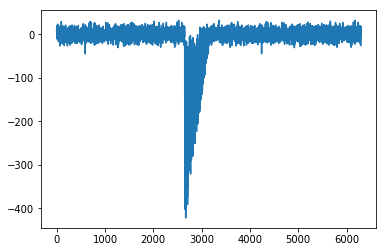

In [28]:
plt.plot(pipe.tracking_error)

## Conclusions

* If the process we are seeking to model is fixed (i.e. does not vary through time) then we can simply do a one-off training routine to fit an ML pipline and serve the pipeline for inference (scoring).

* If the process we are seeking to model varies through time then we need to retrain the ML pipeline on an ongoing basis. However, we have demonstrated that using all the available data at retraining time can lead to large errors on unseen data and therefore it is more beneficial to use a sliding window methodology since the model adapts quicker to the underlying changes in the process.